# **馬の健康への影響を予測する**
[Predict Health Outcomes of Horses](https://www.kaggle.com/competitions/playground-series-s3e22/overview)

# 参考資料
**書籍**


**Kaggle**
- [PS 3.22 LGBM_multiclass_日本語あり](https://www.kaggle.com/code/akioonodera/ps-3-22-lgbm-multiclass)
- [[PG S3 E22]📊EDA + Modeling📈](https://www.kaggle.com/code/yaaangzhou/pg-s3-e22-eda-modeling)

**記事**

**自分で作成したファイル**
- モース硬度データセットを使用した回帰
- 生体信号を使用した喫煙者の状態のバイナリ予測
- ソフトウェア欠陥データセットによるバイナリ分類
- 肝硬変の転帰の多クラス予測
- タイタニック_災害からの機械学習
- Home Credit Default Risk

**その他**

## 概要
1. 目的：
2. 目次:
    * ライブラリ・データセットのインポート
    * EDA
3. データセット:
4. 目的変数： 'outcome'(object)
5. コンペのゴール

### 各特徴量の日本語訳

| 列名                     | 説明                           |
|--------------------------|--------------------------------|
| surgery                  | 手術                           |
| age                      | 年齢                           |
| hospital_number          | 病院番号                       |
| rectal_temp              | 直腸温度                       |
| pulse                    | 心拍数                         |
| respiratory_rate         | 呼吸数                         |
| temp_of_extremities      | 四肢の温度                     |
| peripheral_pulse         | 抹消脈拍                       |
| mucous_membrane          | 粘膜（口腔などの色）           |
| capillary_refill_time    | 毛細管再充填時間               |
| pain                     | 痛み                           |
| peristalsis              | 筋肉が伝播性の収縮派を生み出す運動 |
| abdominal_distention     | 腹部膨満                       |
| nasogastric_tube         | 経鼻胃管                       |
| nasogastric_reflux       | 鼻胃逆流症                     |
| nasogastric_reflux_ph    | 鼻胃逆流症のペーハー           |
| rectal_exam_feces        | 直腸検査の便                   |
| abdomen                  | 腹部                           |
| packed_cell_volume       | 血球容積                       |
| total_protein            | 総タンパク質                   |
| abdomo_appearance        | 腹部の外観                     |
| abdomo_protein           | 腹部タンパク質                 |
| surgical_lesion          | 外科的病変                     |
| lesion                   | 病変                           |
| cp_data                  | ?                              |


#### 評価指標： micro-averaged F1-Score

# ライブラリ・データセットのインポート

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

# pd.set_option('display.max_columns', 30)
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
plt.style.use('ggplot')

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

# 敵対性の検証で用いる
from category_encoders import OneHotEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

## 実行時間を調べるために使う

In [9]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [10]:
FILE_PATH = ''
OUTPUT_DIR = ''

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

## id と目的変数の分割

In [11]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['outcome']

target_name = str(train.iloc[:, [-1]].columns.tolist())
print(target_name)

['outcome']


## データ(DataFrame)の構成を調べる

In [12]:
train.head()

surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
0     yes  adult           530001         38.1  132.0              24.0   
1     yes  adult           533836         37.5   88.0              12.0   
2     yes  adult           529812         38.3  120.0              28.0   
3     yes  adult          5262541         37.1   72.0              30.0   
4      no  adult          5299629         38.0   52.0              48.0   

  temp_of_extremities peripheral_pulse mucous_membrane capillary_refill_time  \
0                cool          reduced   dark_cyanotic            more_3_sec   
1                cool           normal   pale_cyanotic            more_3_sec   
2                cool          reduced       pale_pink            less_3_sec   
3                cold          reduced       pale_pink            more_3_sec   
4              normal           normal     normal_pink            less_3_sec   

           pain peristalsis abdominal_distention nasogastric_tube  \
0     depressed      absent               slight           slight   
1     mild_pain      absent             moderate             none   
2  extreme_pain  hypomotile             moderate           slight   
3     mild_pain  hypomotile             moderate           slight   
4         alert  hypomotile                 none           slight   

  nasogastric_reflux  nasogastric_reflux_ph rectal_exam_feces        abdomen  \
0       less_1_liter                    6.5         decreased  distend_small   
1       more_1_liter                    2.0            absent  distend_small   
2               none                    3.5               NaN  distend_large   
3       more_1_liter                    2.0         decreased  distend_small   
4       less_1_liter                    7.0            normal         normal   

   packed_cell_volume  total_protein abdomo_appearance  abdomo_protein  \
0                57.0            8.5     serosanguious             3.4   
1                33.0           64.0     serosanguious             2.0   
2                37.0            6.4     serosanguious             3.4   
3                53.0            7.0            cloudy             3.9   
4                47.0            7.3            cloudy             2.6   

  surgical_lesion  lesion_1  lesion_2  lesion_3 cp_data     outcome  
0             yes      2209         0         0      no        died  
1             yes      2208         0         0      no  euthanized  
2             yes      5124         0         0      no       lived  
3             yes      2208         0         0     yes       lived  
4              no         0         0         0     yes       lived

In [13]:
test.head()

surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
0      no  adult           534053         38.6   40.0              20.0   
1     yes  adult           528469         38.2  112.0              48.0   
2     yes  adult           528178         37.7   66.0              12.0   
3      no  adult           534784         37.1   88.0              20.0   
4     yes  adult           529840         38.3   50.0              12.0   

  temp_of_extremities peripheral_pulse mucous_membrane capillary_refill_time  \
0              normal           normal     normal_pink            less_3_sec   
1                cool          reduced     bright_pink            more_3_sec   
2                cool           normal      bright_red            less_3_sec   
3                cool          reduced   pale_cyanotic            less_3_sec   
4                 NaN           normal     bright_pink            less_3_sec   

        pain peristalsis abdominal_distention nasogastric_tube  \
0  mild_pain  hypomotile               slight             none   
1  depressed  hypomotile             moderate           slight   
2  mild_pain  hypomotile               slight           slight   
3  depressed      absent               severe           slight   
4  mild_pain      absent               slight           slight   

  nasogastric_reflux  nasogastric_reflux_ph rectal_exam_feces        abdomen  \
0               none                    7.0            normal  distend_small   
1               none                    3.5         decreased  distend_small   
2               none                    3.0            normal  distend_small   
3       more_1_liter                    2.0            absent  distend_large   
4               none                    3.0         decreased  distend_small   

   packed_cell_volume  total_protein abdomo_appearance  abdomo_protein  \
0                42.0            7.5             clear             2.3   
1                44.0            6.0     serosanguious             2.6   
2                31.5            6.0            cloudy             1.6   
3                75.0           81.0               NaN             1.0   
4                37.0            6.8            cloudy             2.6   

  surgical_lesion  lesion_1  lesion_2  lesion_3 cp_data  
0              no         0         0         0      no  
1              no      2208         0         0     yes  
2             yes      2205         0         0     yes  
3             yes      1400         0         0      no  
4             yes      2208         0         0     yes

In [14]:
print('train: ')
print(train.shape)
print(train.info())
print('\n')
print('test: ')
print(test.shape)
print(test.info())

train: 
(1235, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null 

In [15]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [16]:
with pd.option_context('display.max_rows', 8):
    display(train)

surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
0        yes  adult           530001         38.1  132.0              24.0   
1        yes  adult           533836         37.5   88.0              12.0   
2        yes  adult           529812         38.3  120.0              28.0   
3        yes  adult          5262541         37.1   72.0              30.0   
...      ...    ...              ...          ...    ...               ...   
1231     yes  adult           528570         37.5   60.0              50.0   
1232     yes  young           529685         37.5   84.0              40.0   
1233     yes  adult           534784         38.1   70.0              16.0   
1234     yes  adult           528548         38.1   54.0              36.0   

     temp_of_extremities peripheral_pulse mucous_membrane  \
0                   cool          reduced   dark_cyanotic   
1                   cool           normal   pale_cyanotic   
2                   cool          reduced       pale_pink   
3                   cold          reduced       pale_pink   
...                  ...              ...             ...   
1231                cool          reduced   pale_cyanotic   
1232              normal          reduced     normal_pink   
1233              normal          reduced      bright_red   
1234              normal           normal       pale_pink   

     capillary_refill_time          pain peristalsis abdominal_distention  \
0               more_3_sec     depressed      absent               slight   
1               more_3_sec     mild_pain      absent             moderate   
2               less_3_sec  extreme_pain  hypomotile             moderate   
3               more_3_sec     mild_pain  hypomotile             moderate   
...                    ...           ...         ...                  ...   
1231            less_3_sec     mild_pain  hypomotile               slight   
1232            less_3_sec     mild_pain  hypomotile               slight   
1233            less_3_sec     mild_pain  hypomotile               slight   
1234            less_3_sec     mild_pain      absent                 none   

     nasogastric_tube nasogastric_reflux  nasogastric_reflux_ph  \
0              slight       less_1_liter                    6.5   
1                none       more_1_liter                    2.0   
2              slight               none                    3.5   
3              slight       more_1_liter                    2.0   
...               ...                ...                    ...   
1231           slight               none                    3.0   
1232           slight               none                    3.0   
1233             none       more_1_liter                    2.0   
1234           slight               none                    3.0   

     rectal_exam_feces        abdomen  packed_cell_volume  total_protein  \
0            decreased  distend_small                57.0            8.5   
1               absent  distend_small                33.0           64.0   
2                  NaN  distend_large                37.0            6.4   
3            decreased  distend_small                53.0            7.0   
...                ...            ...                 ...            ...   
1231         decreased  distend_small                35.0            6.4   
1232         increased           firm                40.0            5.9   
1233            absent  distend_small                58.0           74.0   
1234               NaN  distend_small                45.0            6.0   

     abdomo_appearance  abdomo_protein surgical_lesion  lesion_1  lesion_2  \
0        serosanguious             3.4             yes      2209         0   
1        serosanguious             2.0             yes      2208         0   
2        serosanguious             3.4             yes      5124         0   
3               cloudy             3.9             yes      2208         0   
...                .

In [17]:
with pd.option_context('display.max_rows', 8):
    display(test)

surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
0        no  adult           534053         38.6   40.0              20.0   
1       yes  adult           528469         38.2  112.0              48.0   
2       yes  adult           528178         37.7   66.0              12.0   
3        no  adult           534784         37.1   88.0              20.0   
..      ...    ...              ...          ...    ...               ...   
820     yes  adult           535338         37.2  100.0              20.0   
821     yes  adult           529640         39.2  132.0              12.0   
822      no  adult          5287179         38.3   54.0              66.0   
823     yes  adult           528461         38.1   66.0              12.0   

    temp_of_extremities peripheral_pulse mucous_membrane  \
0                normal           normal     normal_pink   
1                  cool          reduced     bright_pink   
2                  cool           normal      bright_red   
3                  cool          reduced   pale_cyanotic   
..                  ...              ...             ...   
820                cool          reduced   pale_cyanotic   
821                cool          reduced   dark_cyanotic   
822              normal           normal     normal_pink   
823                cold           normal     normal_pink   

    capillary_refill_time          pain peristalsis abdominal_distention  \
0              less_3_sec     mild_pain  hypomotile               slight   
1              more_3_sec     depressed  hypomotile             moderate   
2              less_3_sec     mild_pain  hypomotile               slight   
3              less_3_sec     depressed      absent               severe   
..                    ...           ...         ...                  ...   
820            more_3_sec  extreme_pain      absent             moderate   
821            more_3_sec     depressed  hypomotile             moderate   
822            less_3_sec     mild_pain  hypomotile                 none   
823            less_3_sec     mild_pain  hypomotile               slight   

    nasogastric_tube nasogastric_reflux  nasogastric_reflux_ph  \
0               none               none                    7.0   
1             slight               none                    3.5   
2             slight               none                    3.0   
3             slight       more_1_liter                    2.0   
..               ...                ...                    ...   
820           slight       more_1_liter                    2.0   
821           slight       more_1_liter                    6.5   
822           slight               none                    7.0   
823           slight       more_1_liter                    2.0   

    rectal_exam_feces        abdomen  packed_cell_volume  total_protein  \
0              normal  distend_small                42.0            7.5   
1           decreased  distend_small                44.0            6.0   
2              normal  distend_small                31.5            6.0   
3              absent  distend_large                75.0           81.0   
..                ...            ...                 ...            ...   
820            absent  distend_small                50.0           66.0   
821         decreased            NaN                53.0            7.6   
822            normal            NaN                49.0            8.6   
823            absent  distend_small                31.5            6.2   

    abdomo_appearance  abdomo_protein surgical_lesion  lesion_1  lesion_2  \
0               clear             2.3              no         0         0   
1       serosanguious             2.6              no      2208         0   
2              cloudy             1.6             yes      2205         0   
3                 NaN             1.0             yes      1400         0   
..                ...             ...             ...       ...       ... 

## データ型を理解する

In [18]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
surgery                   object
age                       object
hospital_number            int64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities       object
peripheral_pulse          object
mucous_membrane           object
capillary_refill_time     object
pain                      object
peristalsis               object
abdominal_distention      object
nasogastric_tube          object
nasogastric_reflux        object
nasogastric_reflux_ph    float64
rectal_exam_feces         object
abdomen                   object
packed_cell_volume       float64
total_protein            float64
abdomo_appearance         object
abdomo_protein           float64
surgical_lesion           object
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                   object
outcome                   object
dtype: object
object     17
float64     7
int64       4
Name: count,

In [19]:
# 説明変数をデータ型ごとに代入する
numerical_features = test._get_numeric_data().columns
categorical_features = test.drop(numerical_features, axis=1).columns
numerical_features, categorical_features

(Index(['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate',
        'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein',
        'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3'],
       dtype='object'),
 Index(['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
        'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
        'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
        'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion',
        'cp_data'],
       dtype='object'))

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 要約統計量

In [20]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

In [59]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

In [61]:
desc_train = pd.DataFrame(index=list(train))
desc_train['count'] = train.count()
desc_train['nunique'] = train.nunique()
desc_train['%unique'] = desc_train['nunique'] / len(train) * 100
desc_train['null'] = train.isnull().sum()
desc_train['type'] = train.dtypes
desc_train = desc_train.style.background_gradient(cmap='Greens')
# desc_train = pd.concat([desc_train, train.describe().T], axis=1)
desc_train

In [62]:
desc_test = pd.DataFrame(index=list(test))
desc_test['count'] = test.count()
desc_test['nunique'] = test.nunique()
desc_test['%unique'] = desc_test['nunique'] / len(test) * 100
desc_test['null'] = test.isnull().sum()
desc_test['type'] = test.dtypes
desc_test = desc_test.style.background_gradient(cmap='Blues')
# desc_test = pd.concat([desc_test, test.describe().T], axis=1)
desc_test

In [24]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train[numerical_features], axis=0))
print('\n')
print('test: ')
print(np.var(test[numerical_features], axis=0))

train: 
hospital_number          1.838340e+12
rectal_temp              6.214932e-01
pulse                    8.466267e+02
respiratory_rate         2.704513e+02
nasogastric_reflux_ph    3.750312e+00
packed_cell_volume       1.109132e+02
total_protein            7.110569e+02
abdomo_protein           2.523497e+00
lesion_1                 2.953414e+07
lesion_2                 3.749153e+04
lesion_3                 7.889520e+03
dtype: float64


test: 
hospital_number          2.417038e+12
rectal_temp              6.158440e-01
pulse                    8.495481e+02
respiratory_rate         3.035027e+02
nasogastric_reflux_ph    3.543132e+00
packed_cell_volume       1.090729e+02
total_protein            6.968309e+02
abdomo_protein           2.366368e+00
lesion_1                 2.611034e+07
lesion_2                 3.878858e+04
lesion_3                 0.000000e+00
dtype: float64


### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [25]:
train[numerical_features].std() / train[numerical_features].mean()

hospital_number           1.421061
rectal_temp               0.020645
pulse                     0.365805
respiratory_rate          0.547412
nasogastric_reflux_ph     0.442057
packed_cell_volume        0.212405
total_protein             1.247262
abdomo_protein            0.482901
lesion_1                  1.418588
lesion_2                 13.256488
lesion_3                 24.839477
dtype: float64

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [26]:
print('train: ')
print(train[numerical_features].kurtosis())
print('\n')
print('test: ')
print(test[numerical_features].kurtosis())

train: 
hospital_number            6.355652
rectal_temp                1.068378
pulse                      0.124835
respiratory_rate           3.247393
nasogastric_reflux_ph     -1.300207
packed_cell_volume        -0.124601
total_protein              0.120115
abdomo_protein             1.672419
lesion_1                  19.103602
lesion_2                 218.323614
lesion_3                 614.993508
dtype: float64


test: 
hospital_number            3.406059
rectal_temp                0.862256
pulse                      0.112073
respiratory_rate           3.057832
nasogastric_reflux_ph     -1.260324
packed_cell_volume         0.024444
total_protein              0.298897
abdomo_protein             1.815503
lesion_1                  20.538546
lesion_2                 352.079315
lesion_3                   0.000000
dtype: float64


### 目的変数の尖度と歪度

目的変数がobject型であるため算出できなかった

## 欠損値

In [27]:
print('train: ')
print(train.isna().sum().any())
print(train.isnull().sum())
print('\n')
print('test: ')
print(test.isna().sum().any())
print(test.isnull().sum())

train: 
True
surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64


test: 
True
surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
res

Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)


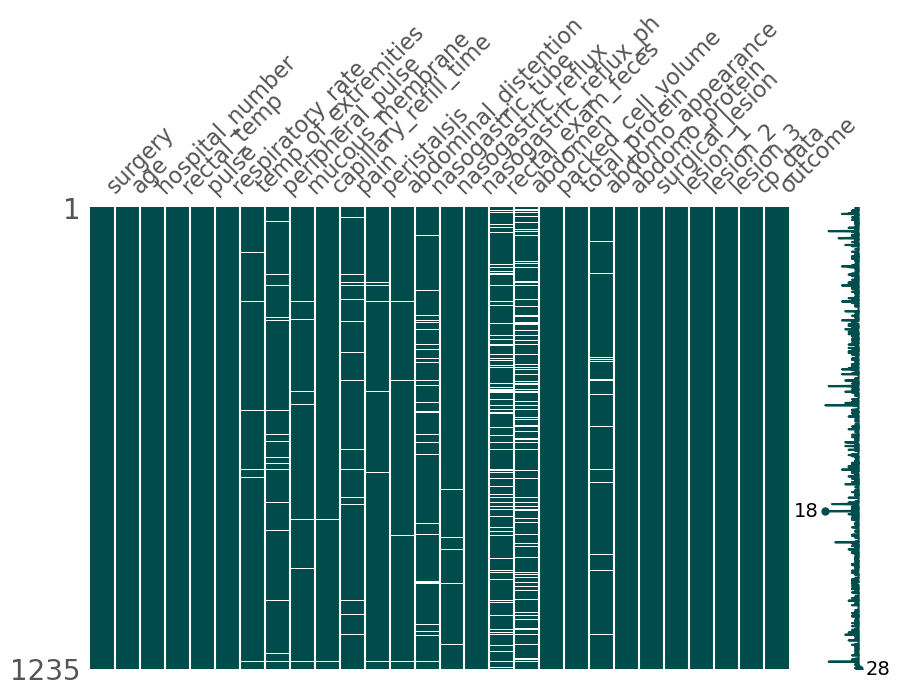

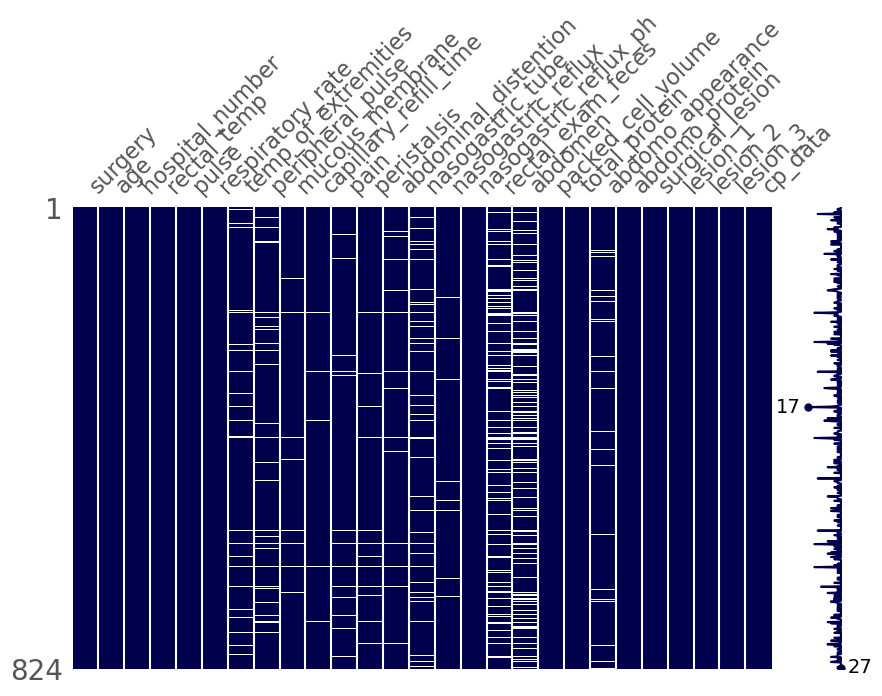

In [28]:
# 欠損値の有無を可視化する
print(msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3)))
print(msno.matrix(df=test, figsize=(10, 6), color=(0, 0, .3)))

元々欠損値がないデータ

## 重複データ

In [29]:
total = pd.concat([train.drop('outcome', axis=1), test], axis=0) # 目的変数を指定する
total.duplicated().sum()

0

## カラムごとのユニークな値を調べる

In [30]:
train[train.columns].nunique().sort_values(ascending=True)

surgery                    2
age                        2
lesion_3                   2
surgical_lesion            2
cp_data                    2
abdomo_appearance          3
capillary_refill_time      3
nasogastric_tube           3
outcome                    3
temp_of_extremities        4
lesion_2                   4
peripheral_pulse           4
abdominal_distention       4
nasogastric_reflux         4
rectal_exam_feces          5
abdomen                    5
peristalsis                5
pain                       6
mucous_membrane            6
nasogastric_reflux_ph     26
respiratory_rate          37
rectal_temp               43
packed_cell_volume        49
pulse                     50
abdomo_protein            54
lesion_1                  57
total_protein             83
hospital_number          255
dtype: int64

### 目的変数

In [31]:
print(target_name +' Class labels:', np.unique(target))

['outcome'] Class labels: ['died' 'euthanized' 'lived']


## データセットのプロット（分布）

### 密度関数（ヒストグラム）

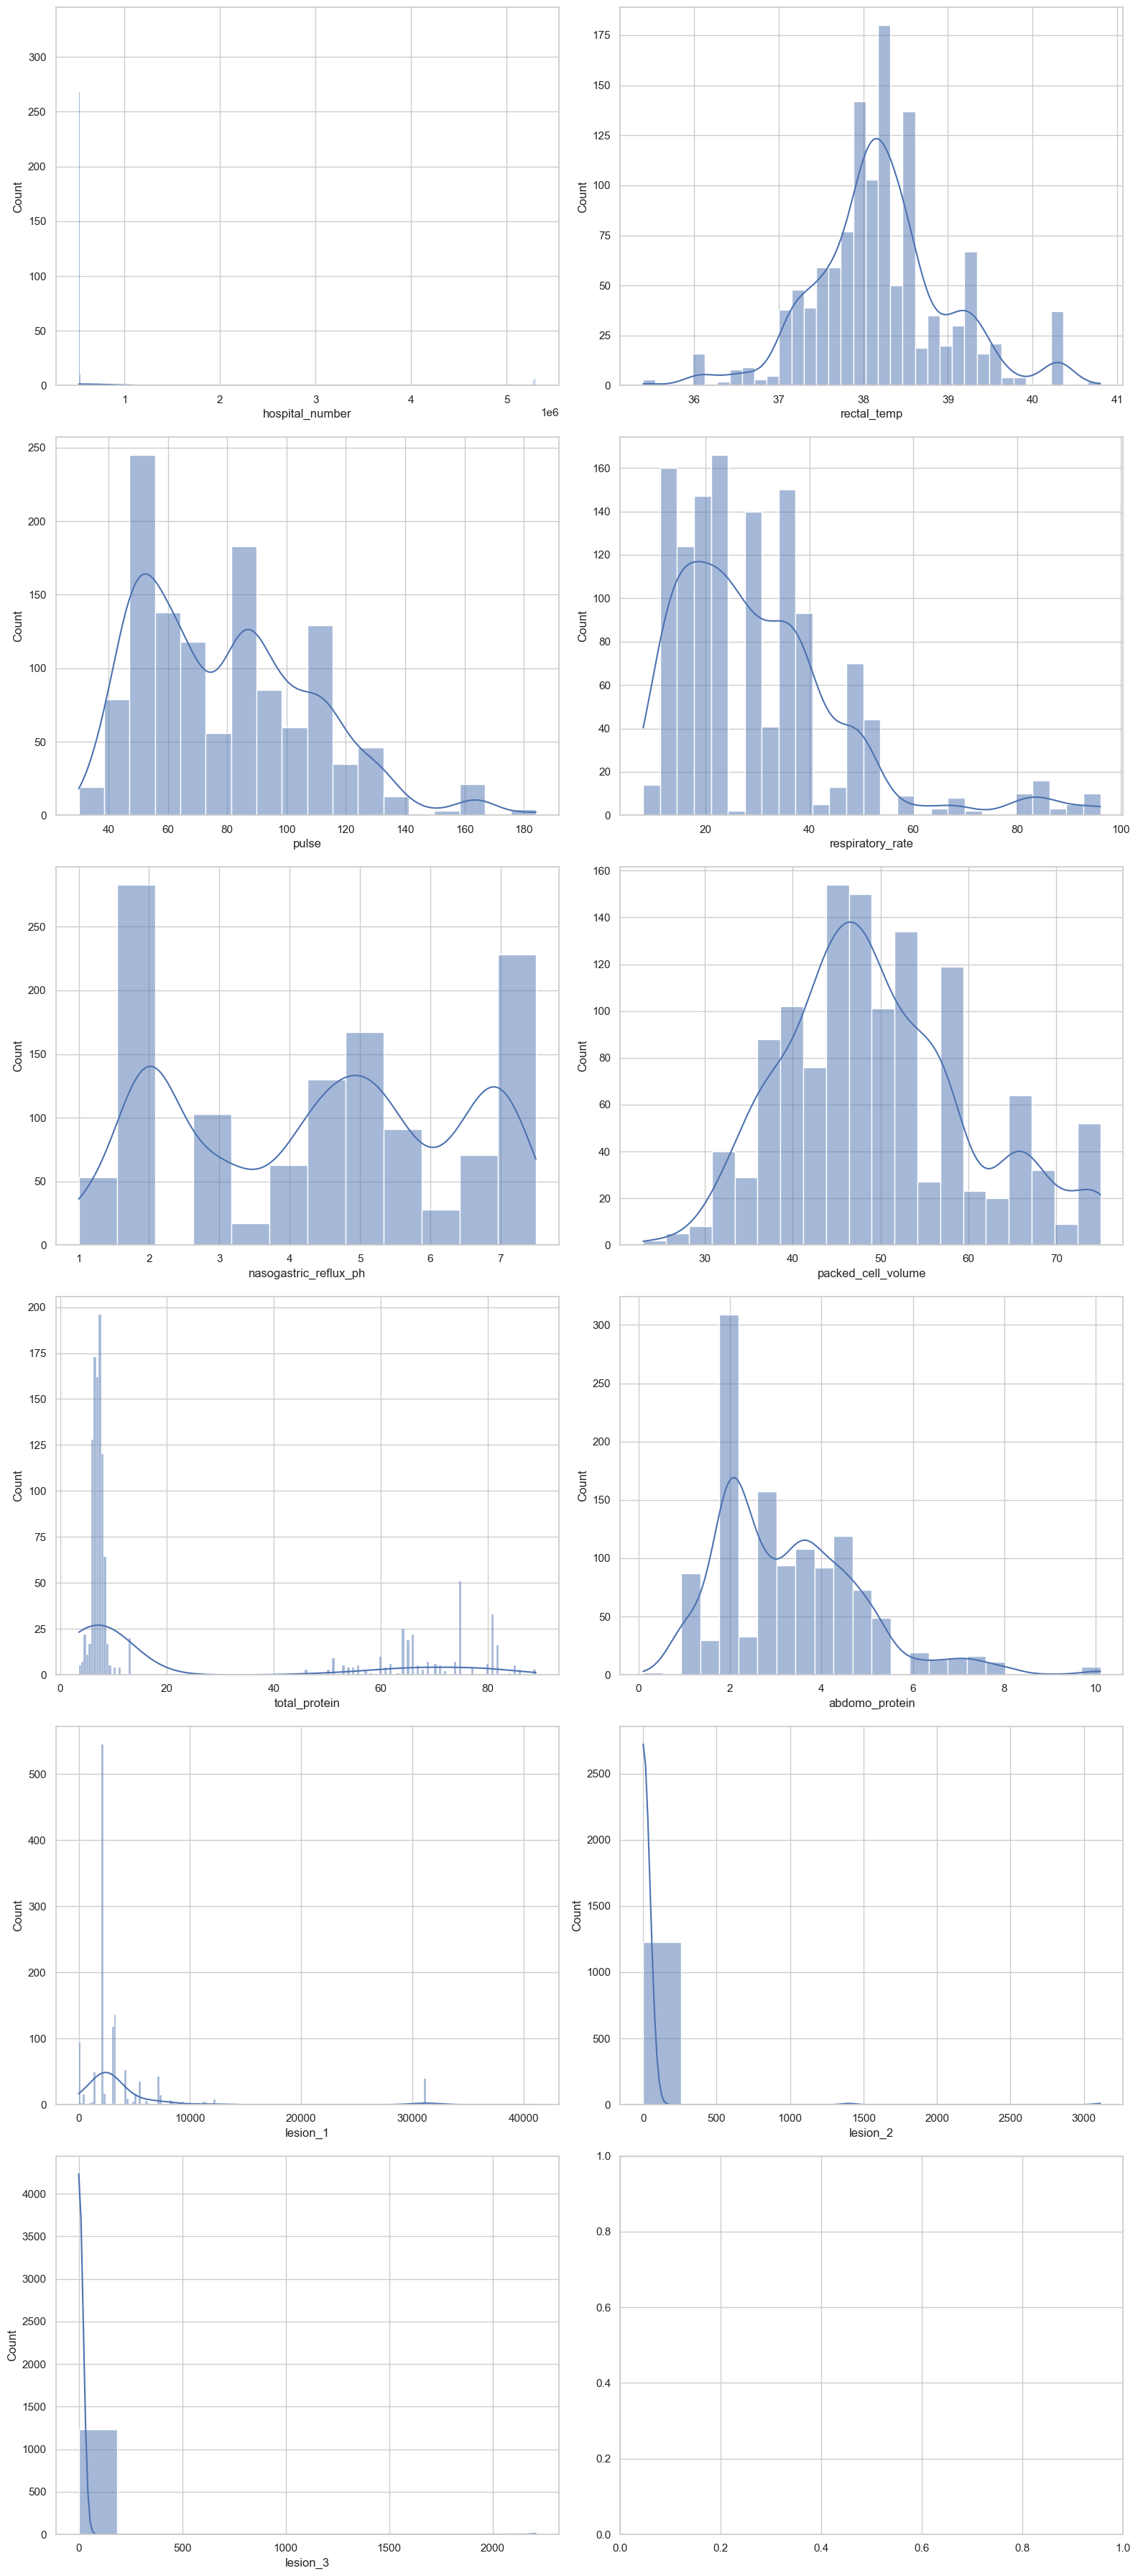

In [32]:
sns.set(style="whitegrid")

rows = (len(numerical_features) + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(numerical_features):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])

plt.tight_layout()

plt.show()

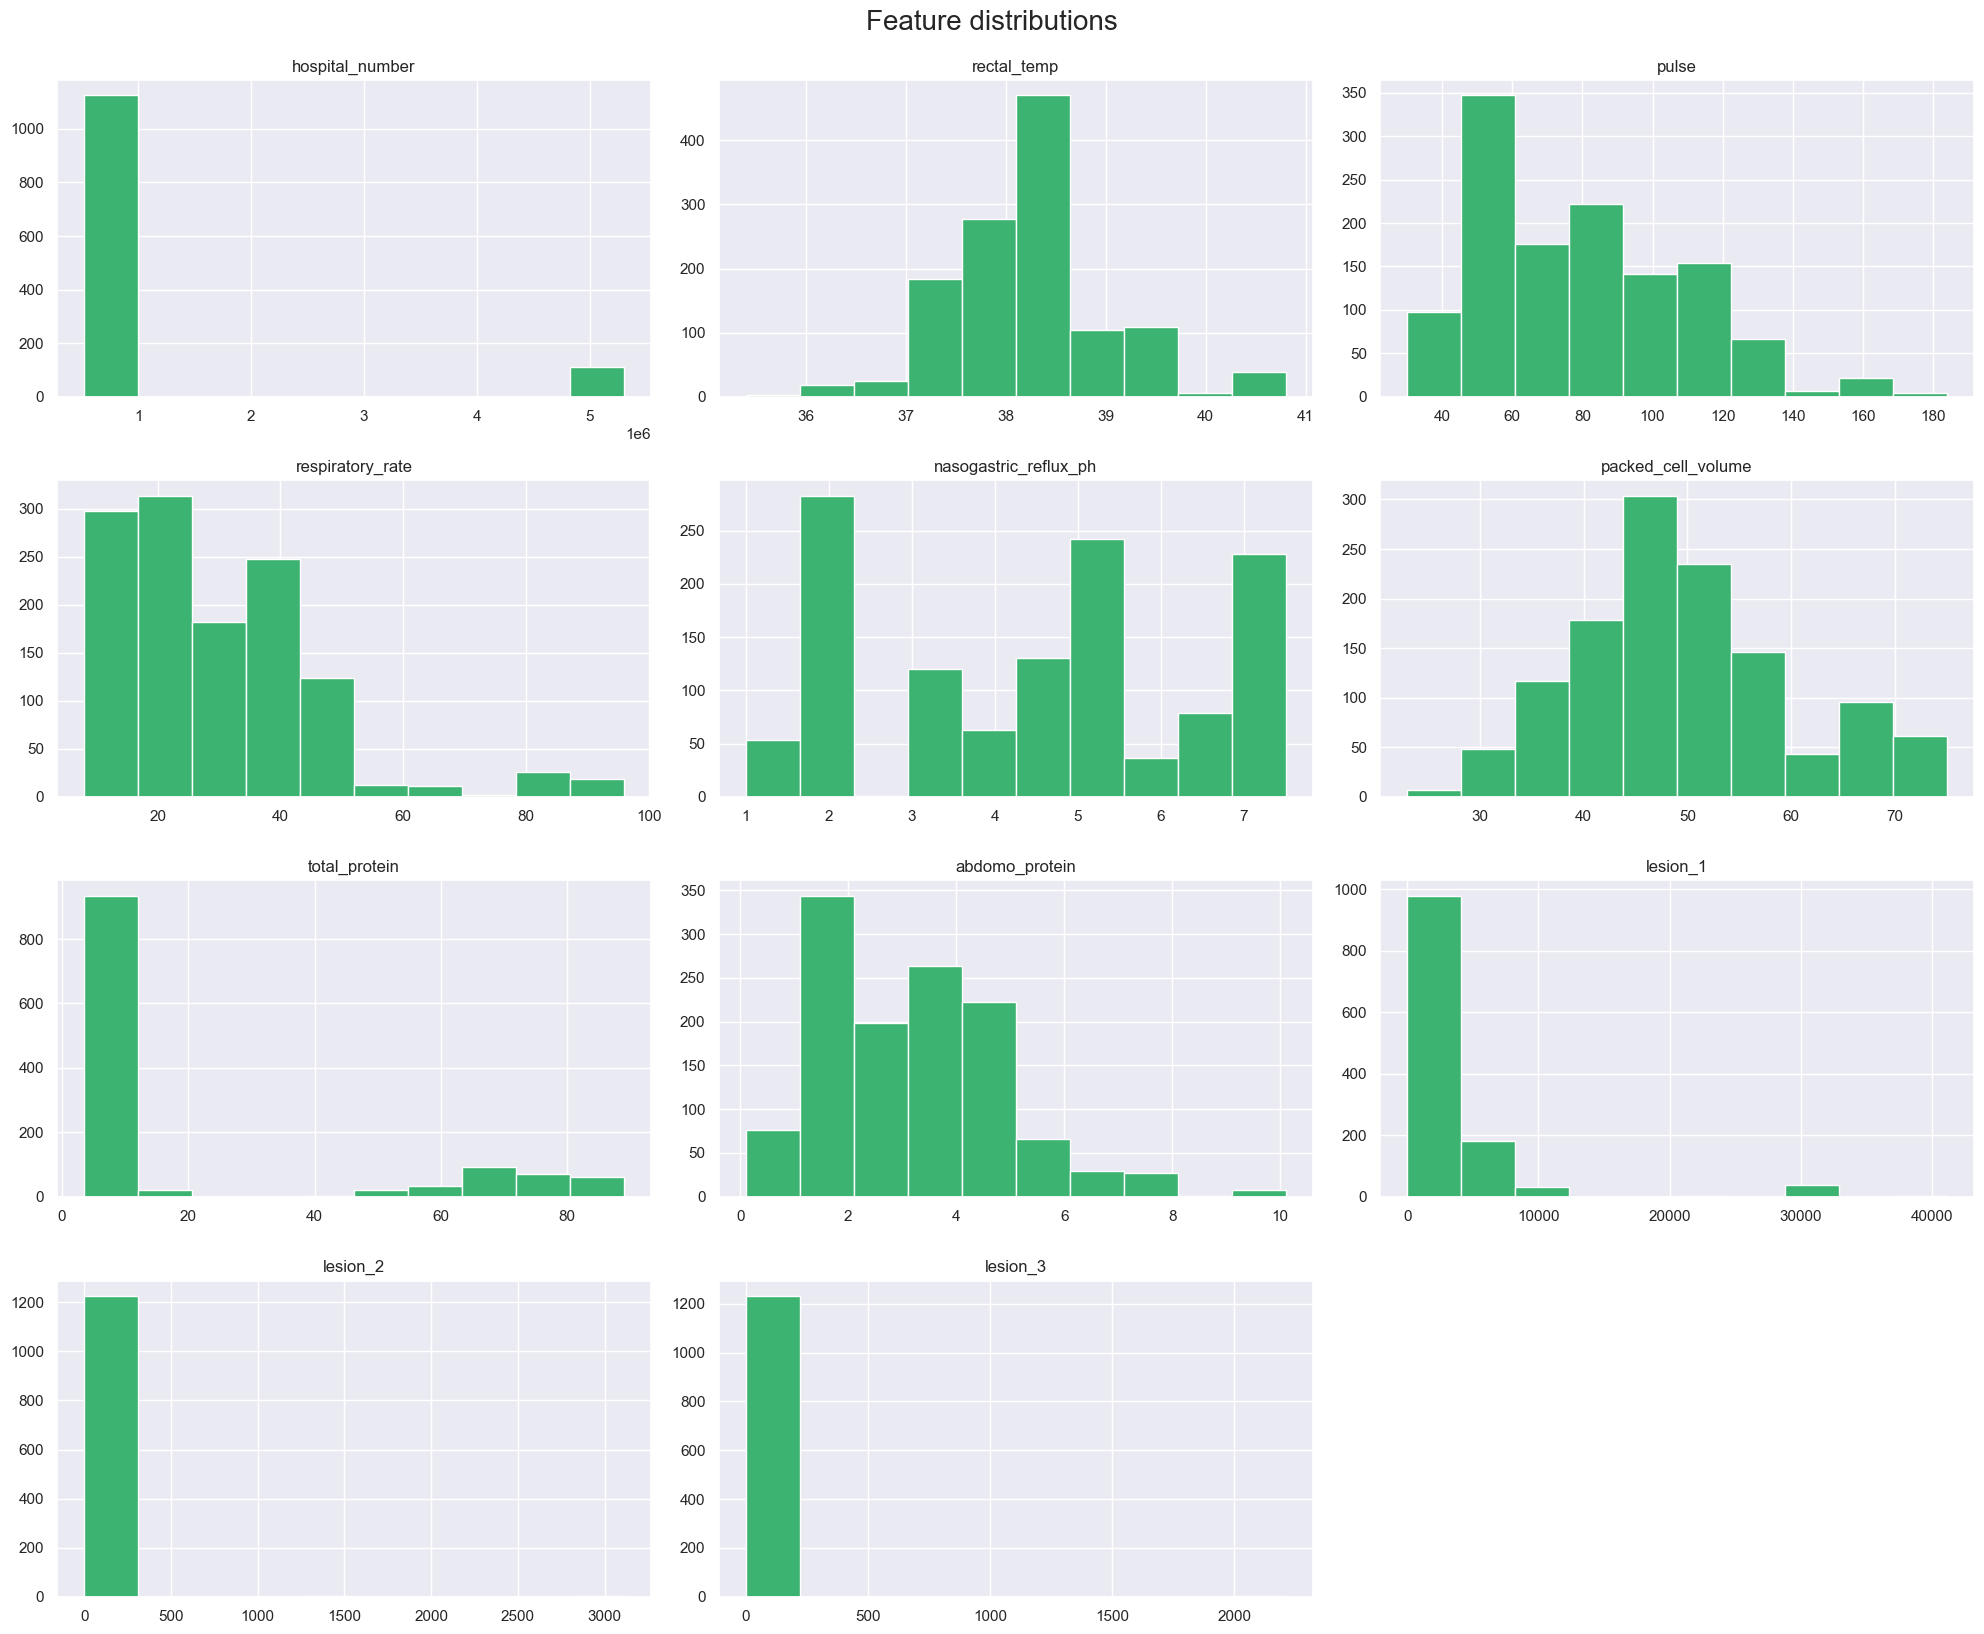

In [33]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

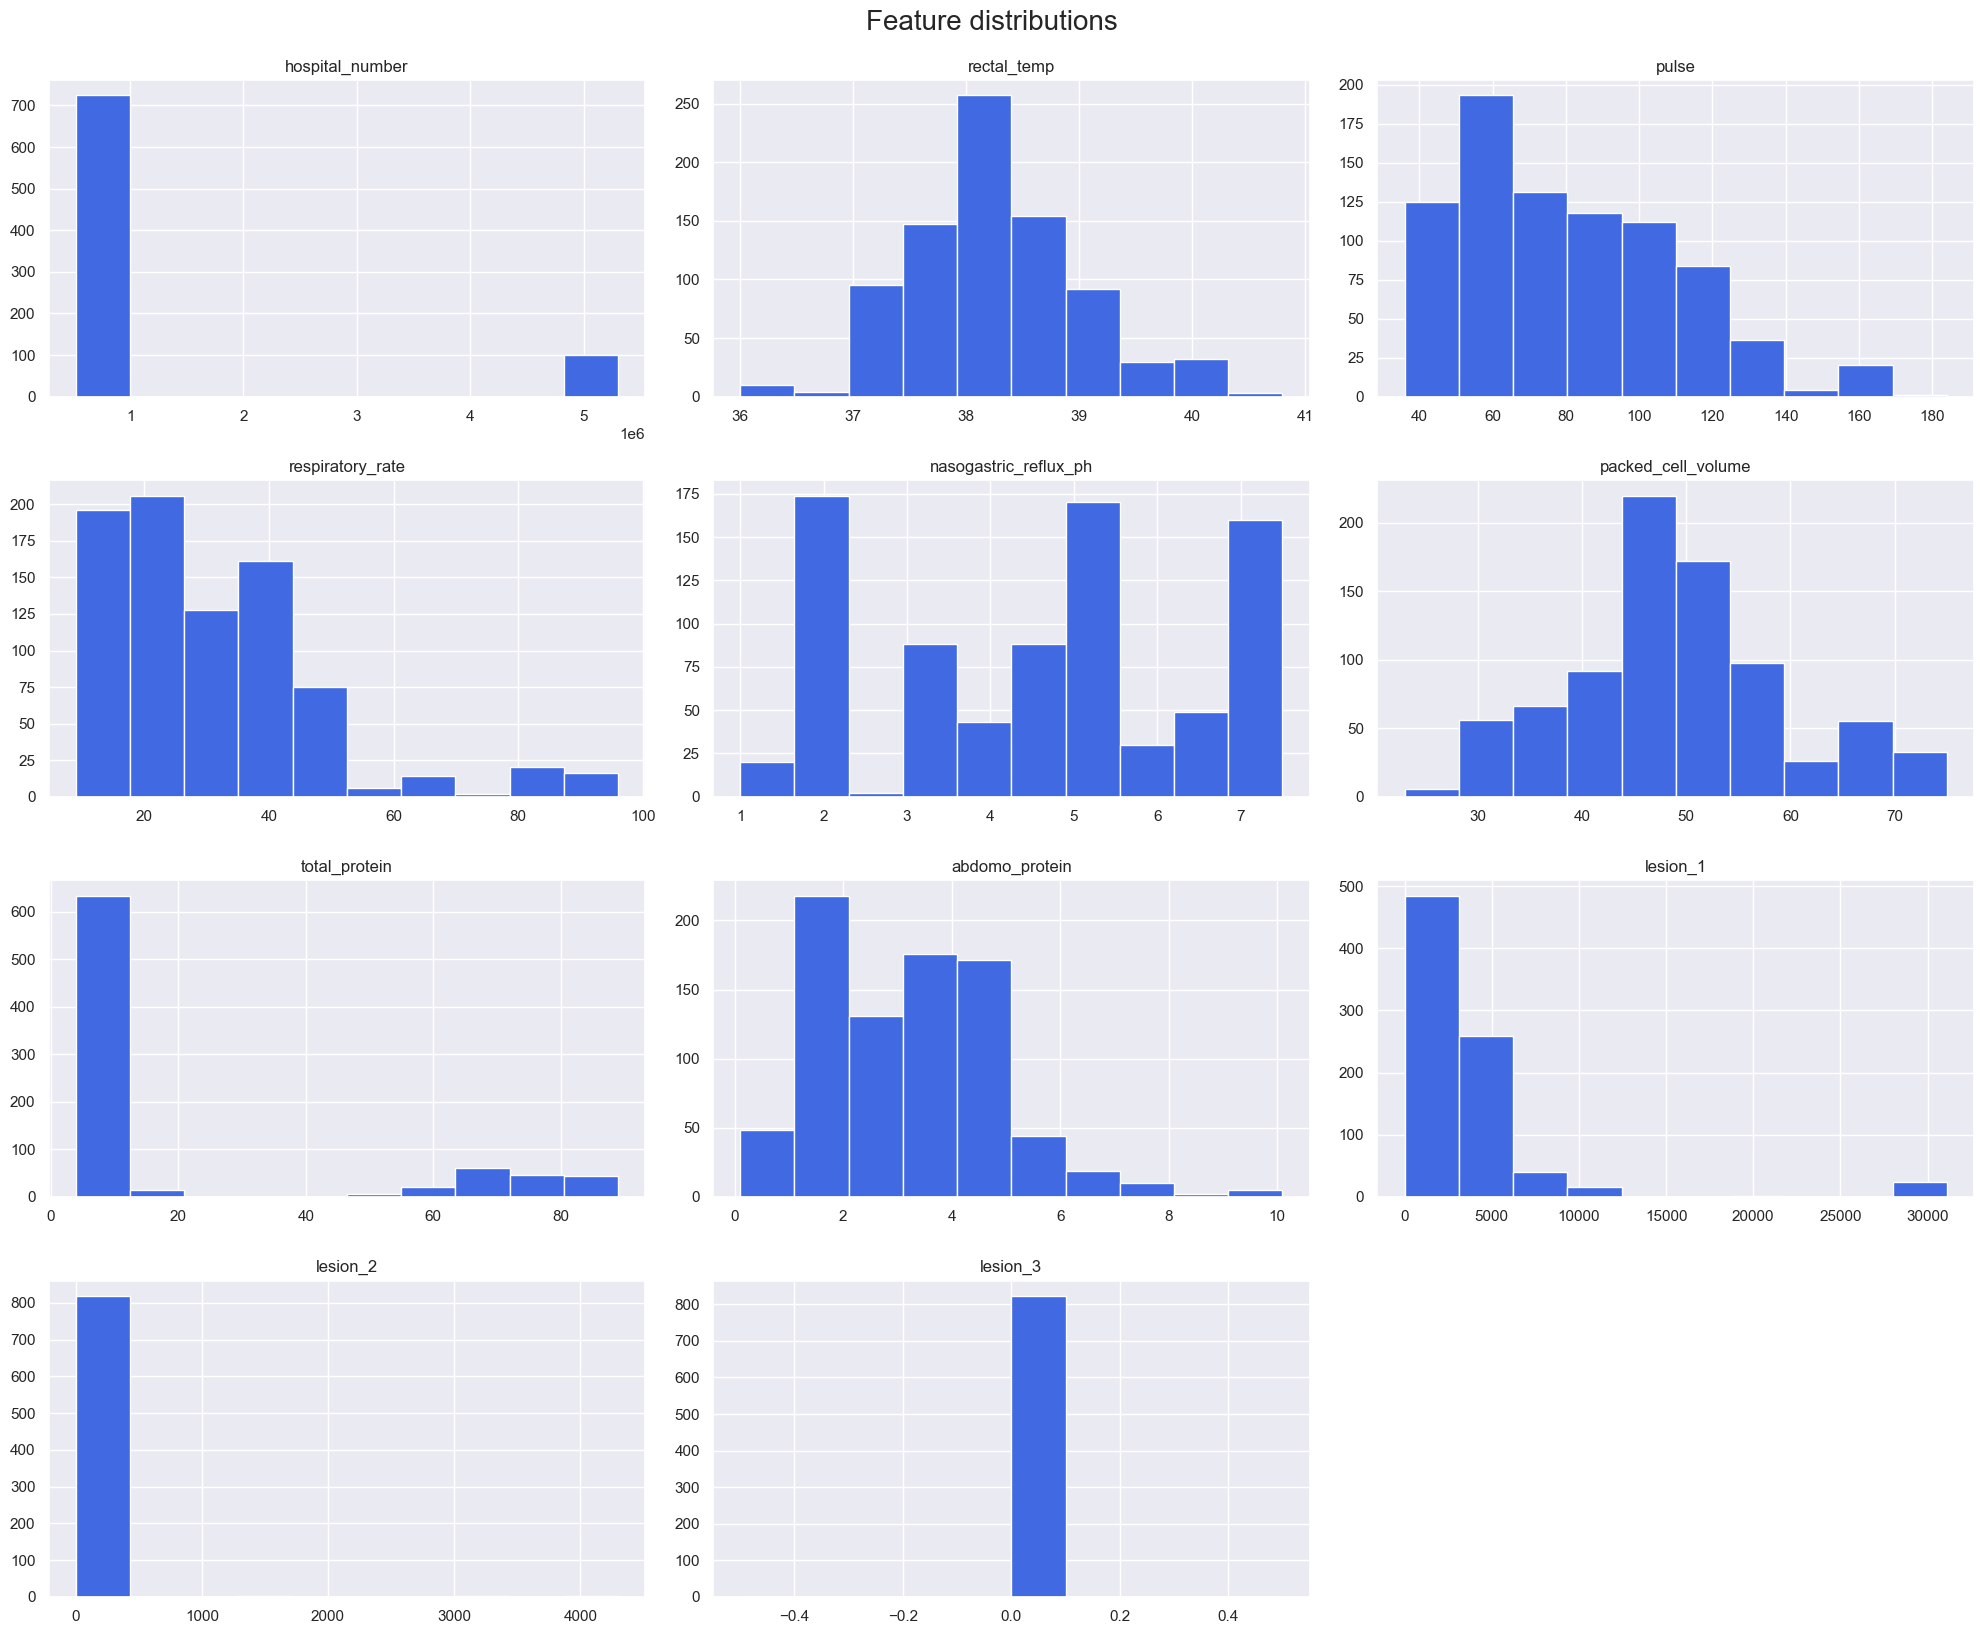

In [34]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

#### データの分布を可視化する

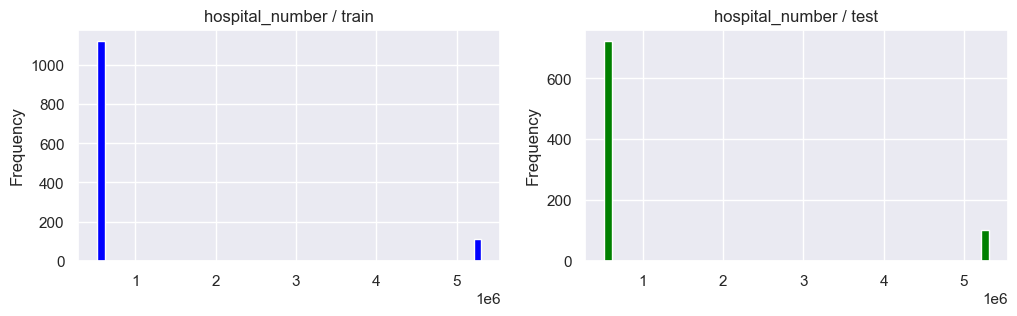

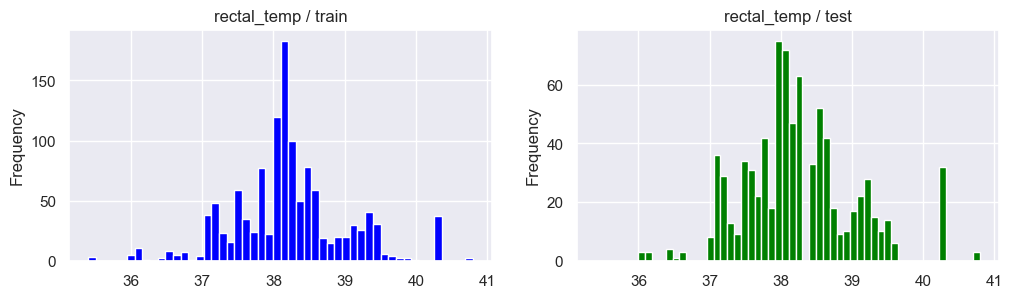

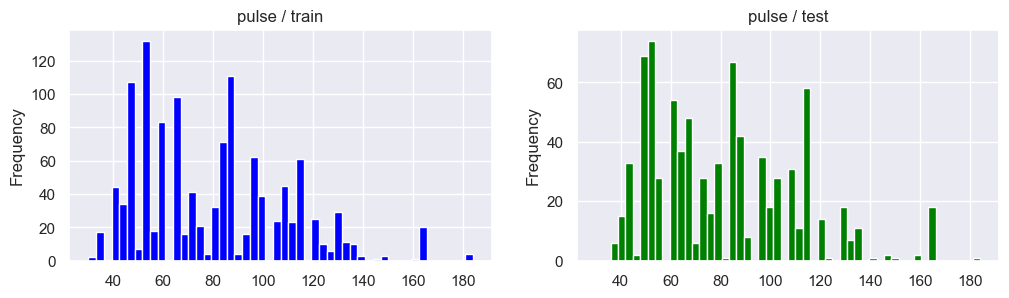

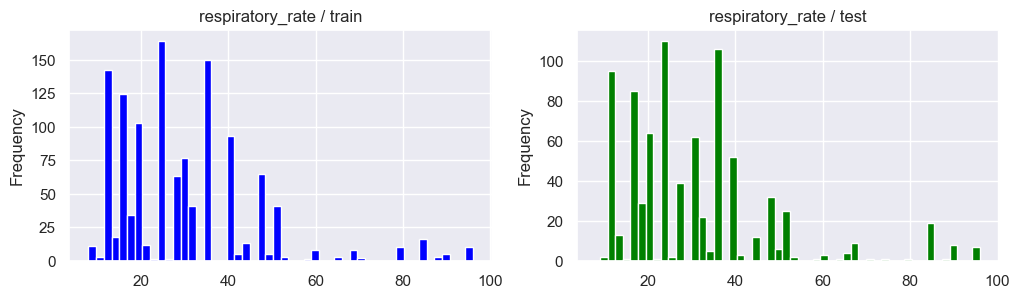

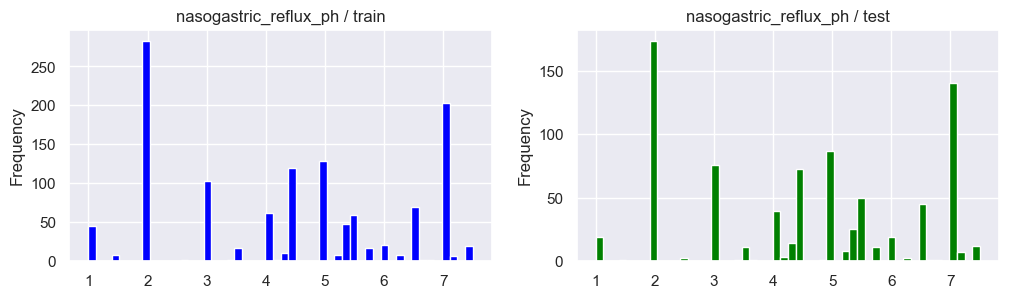

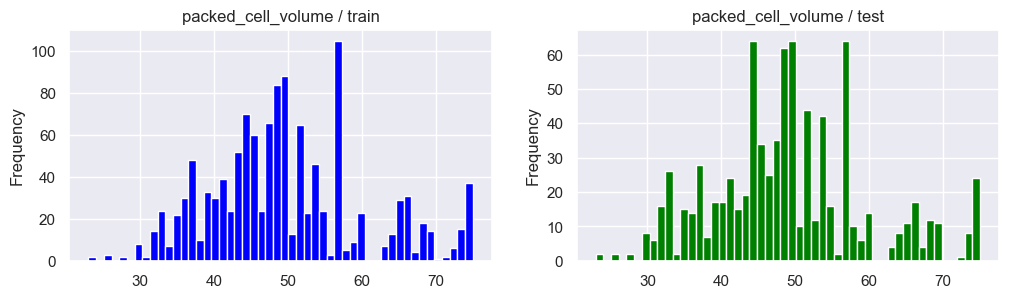

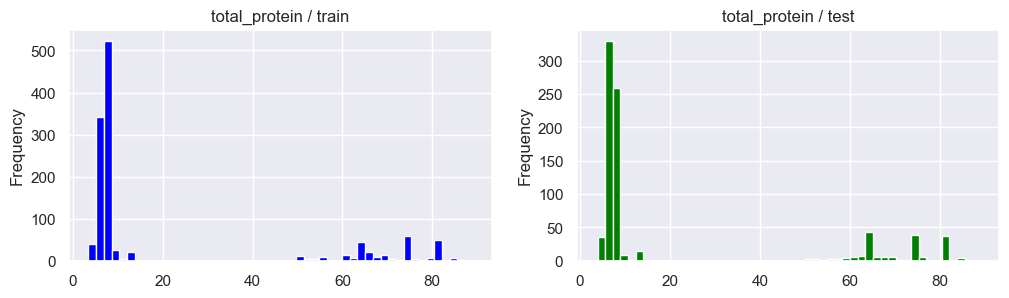

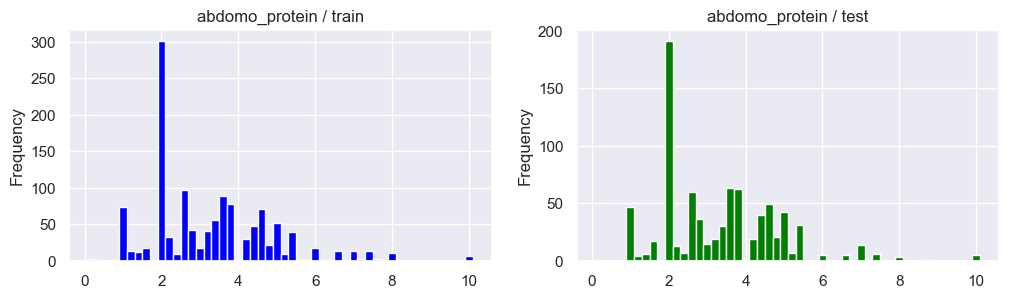

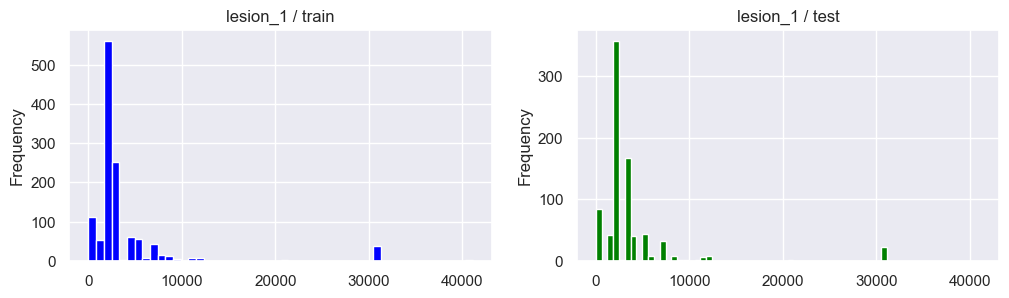

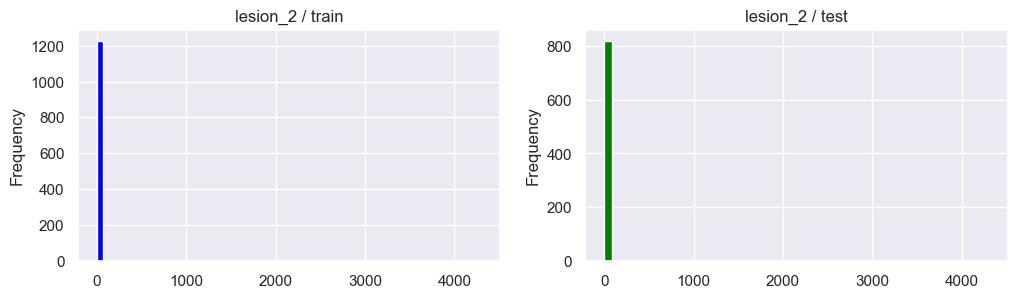

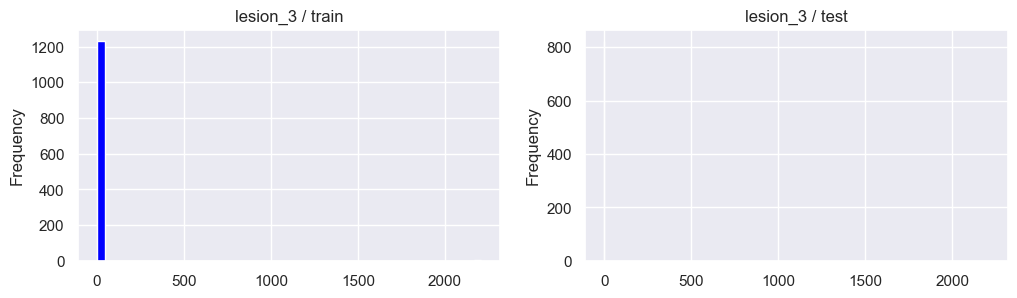

In [35]:
feature = train[numerical_features]

for feat in feature:
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 2, 1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')

    plt.show()

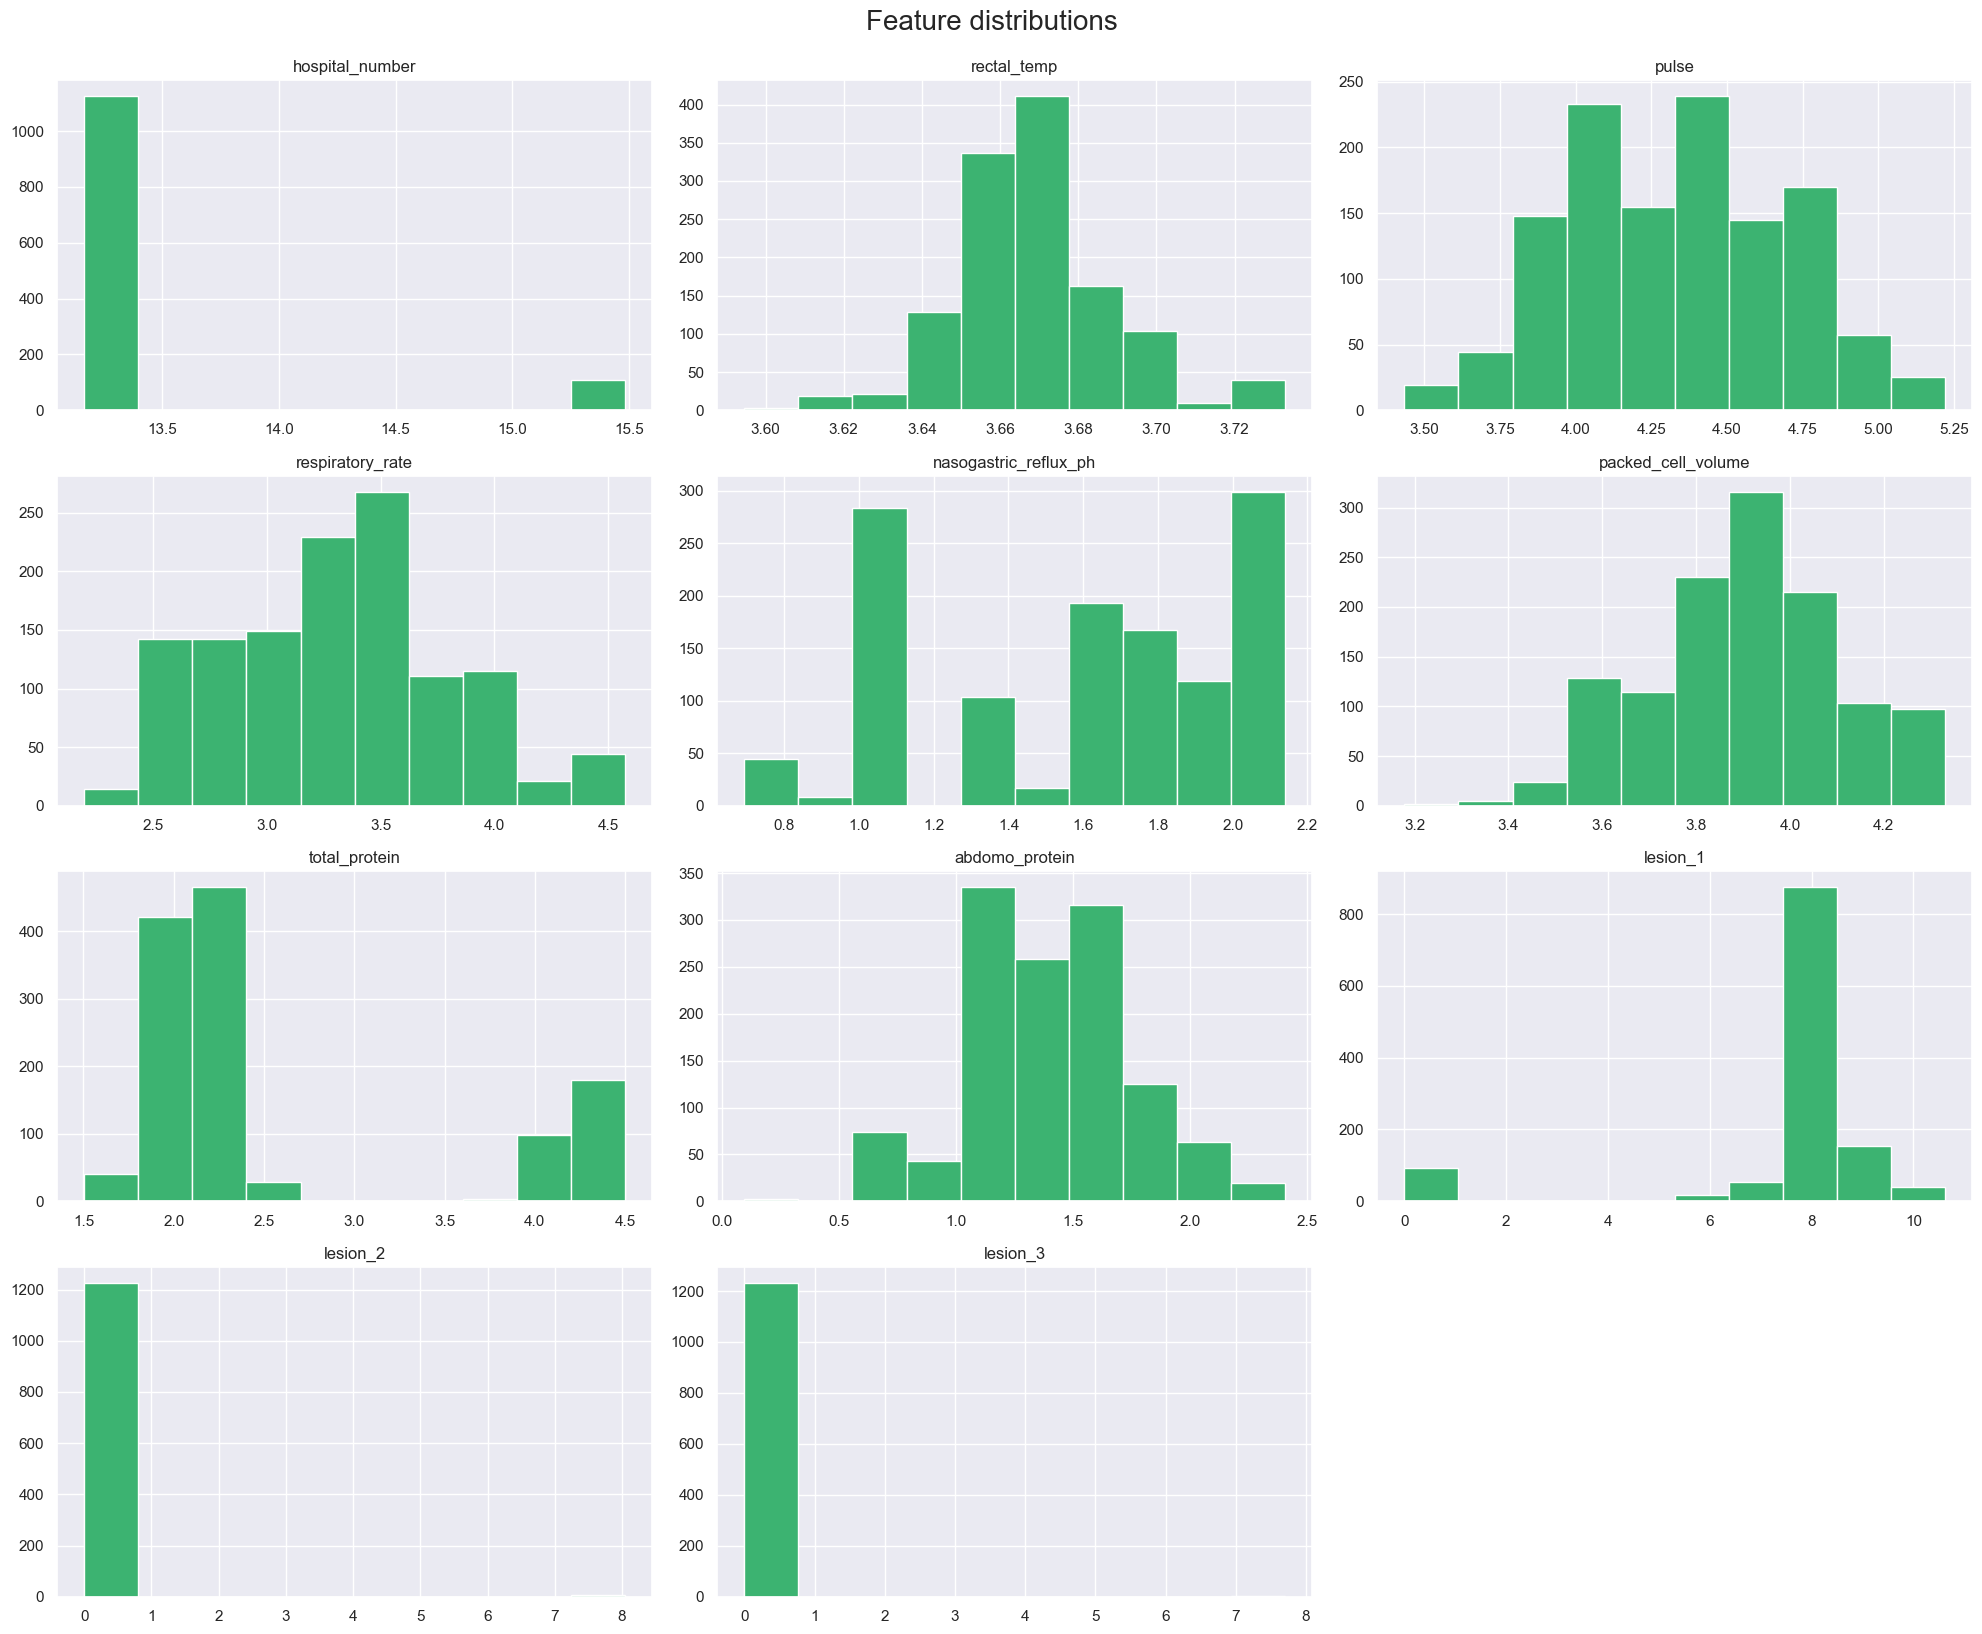

In [36]:
# 訓練データをX(説明変数)とy（目的変数）に分割する
X = train[numerical_features]
y = target

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))

X.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

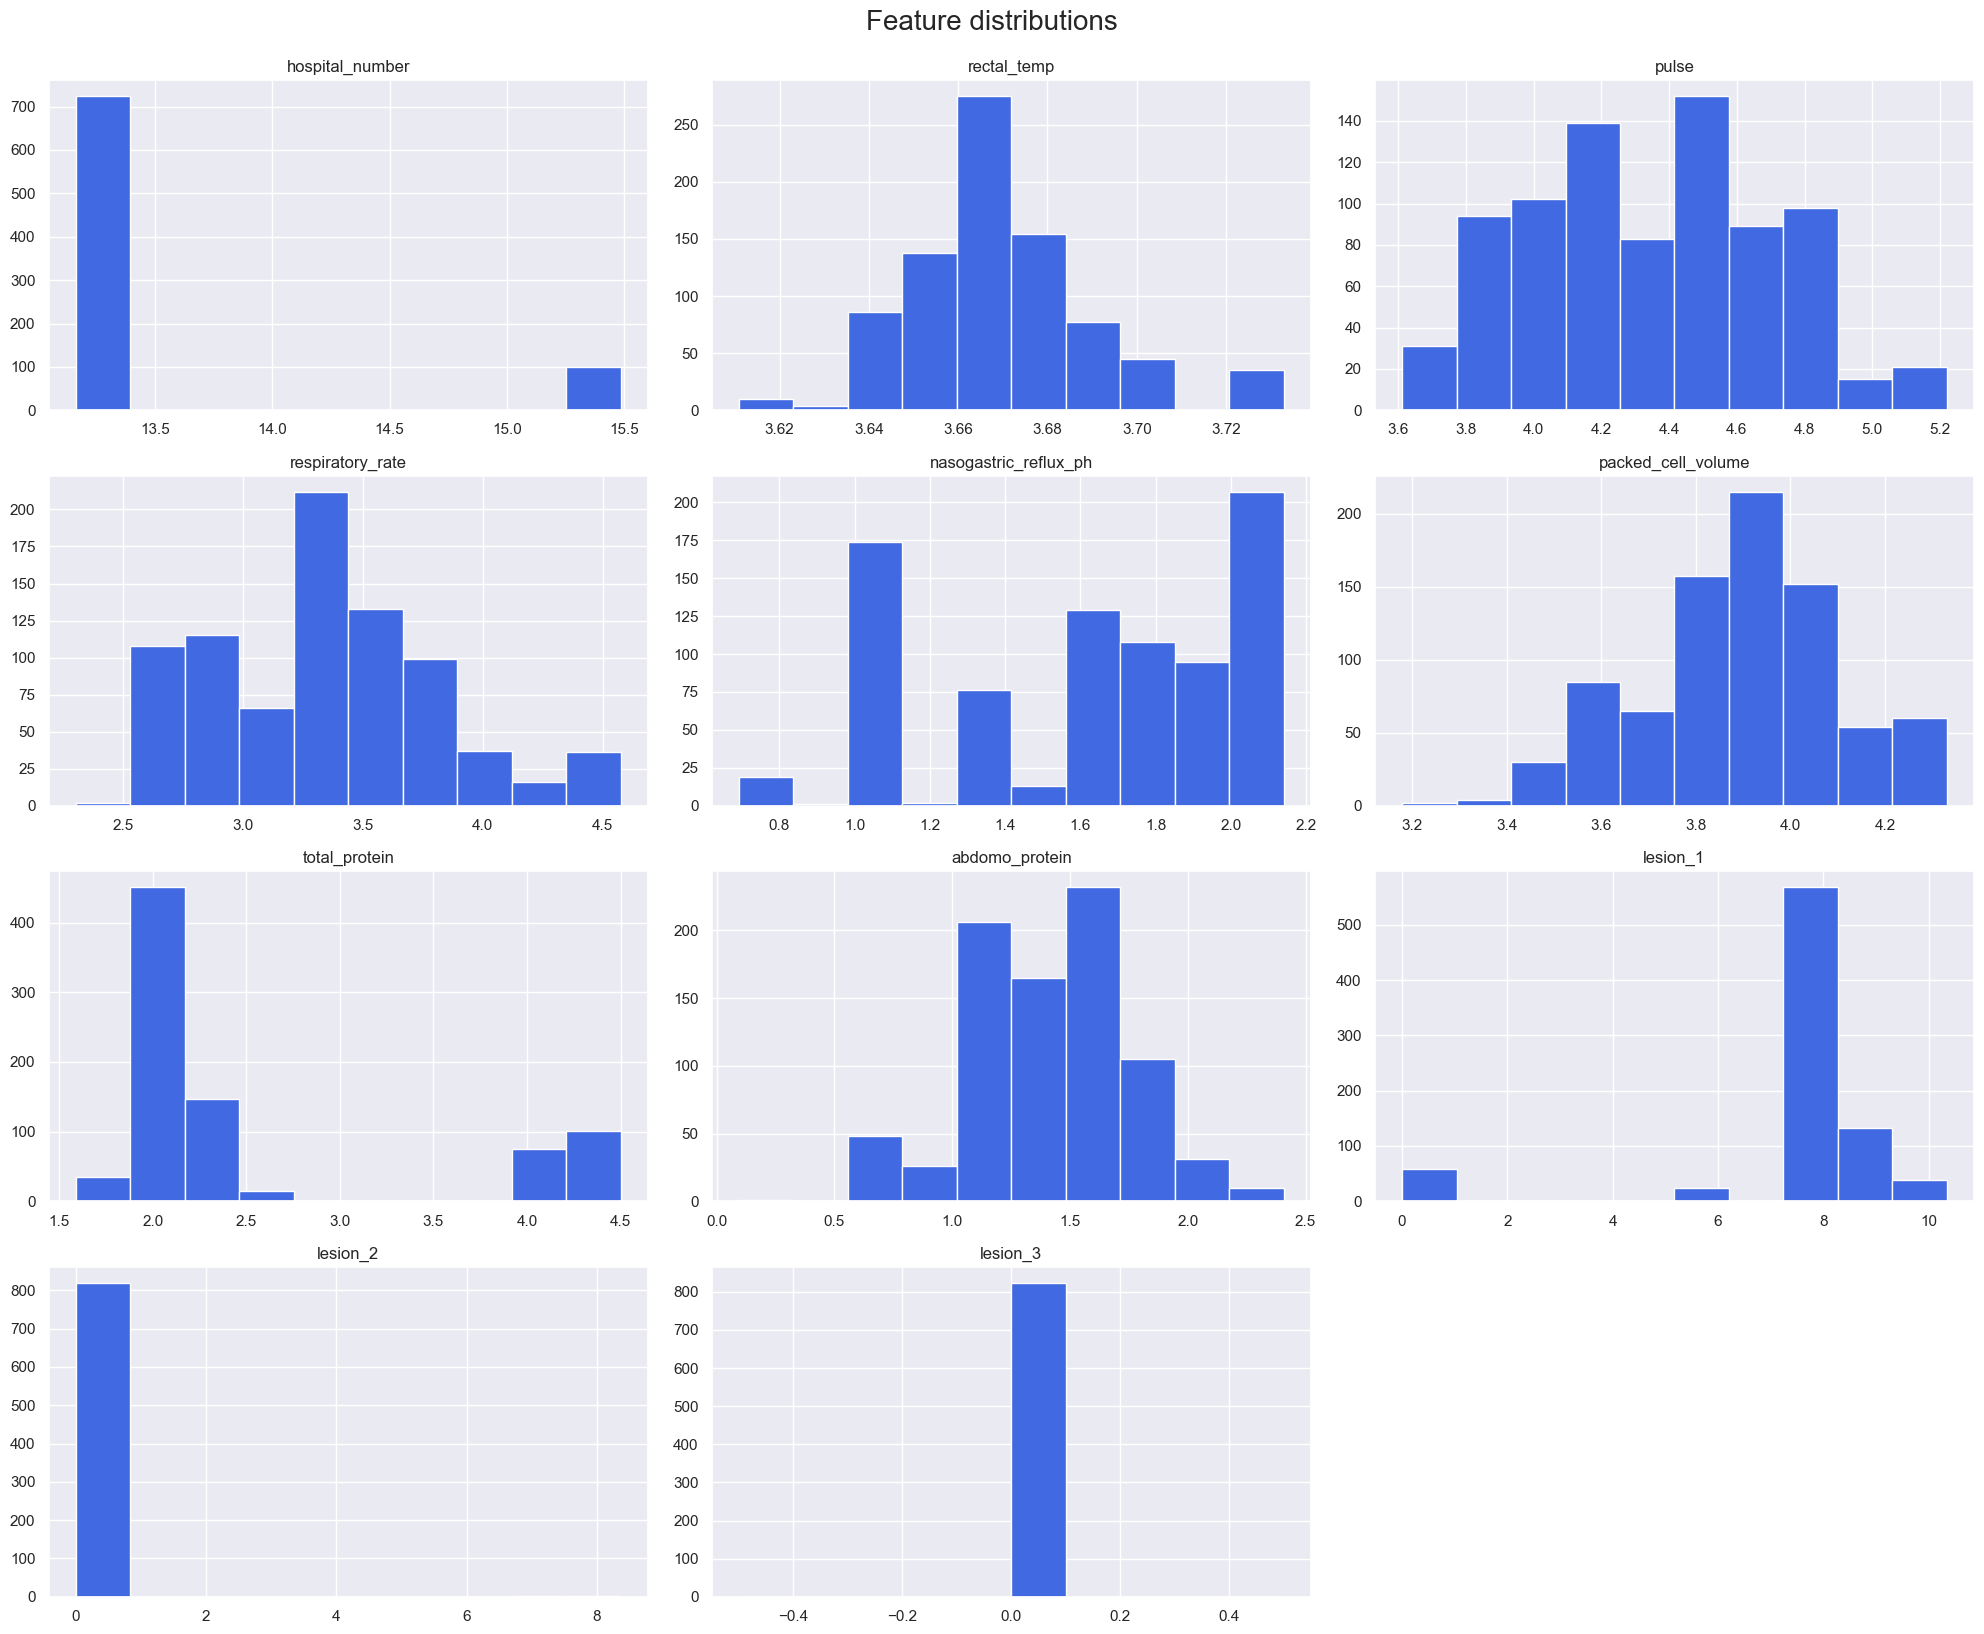

In [37]:
# テストデータも変換する
test_log = test[numerical_features]
for column in test_log.columns.tolist():
    test_log[column] = test_log[column].apply(lambda x: np.log(x + 1))

test_log.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

* 一部の説明変数において分布が確認しやすくなった

#### データを対数変換する

##### 数値型の説明変数の分布

カーネル密度推定（KDE: Kernel Density Estimation）
- 実データから、正規分布曲線のように下部の面積が1となるような連続した曲線（確率密度関数）を推定する

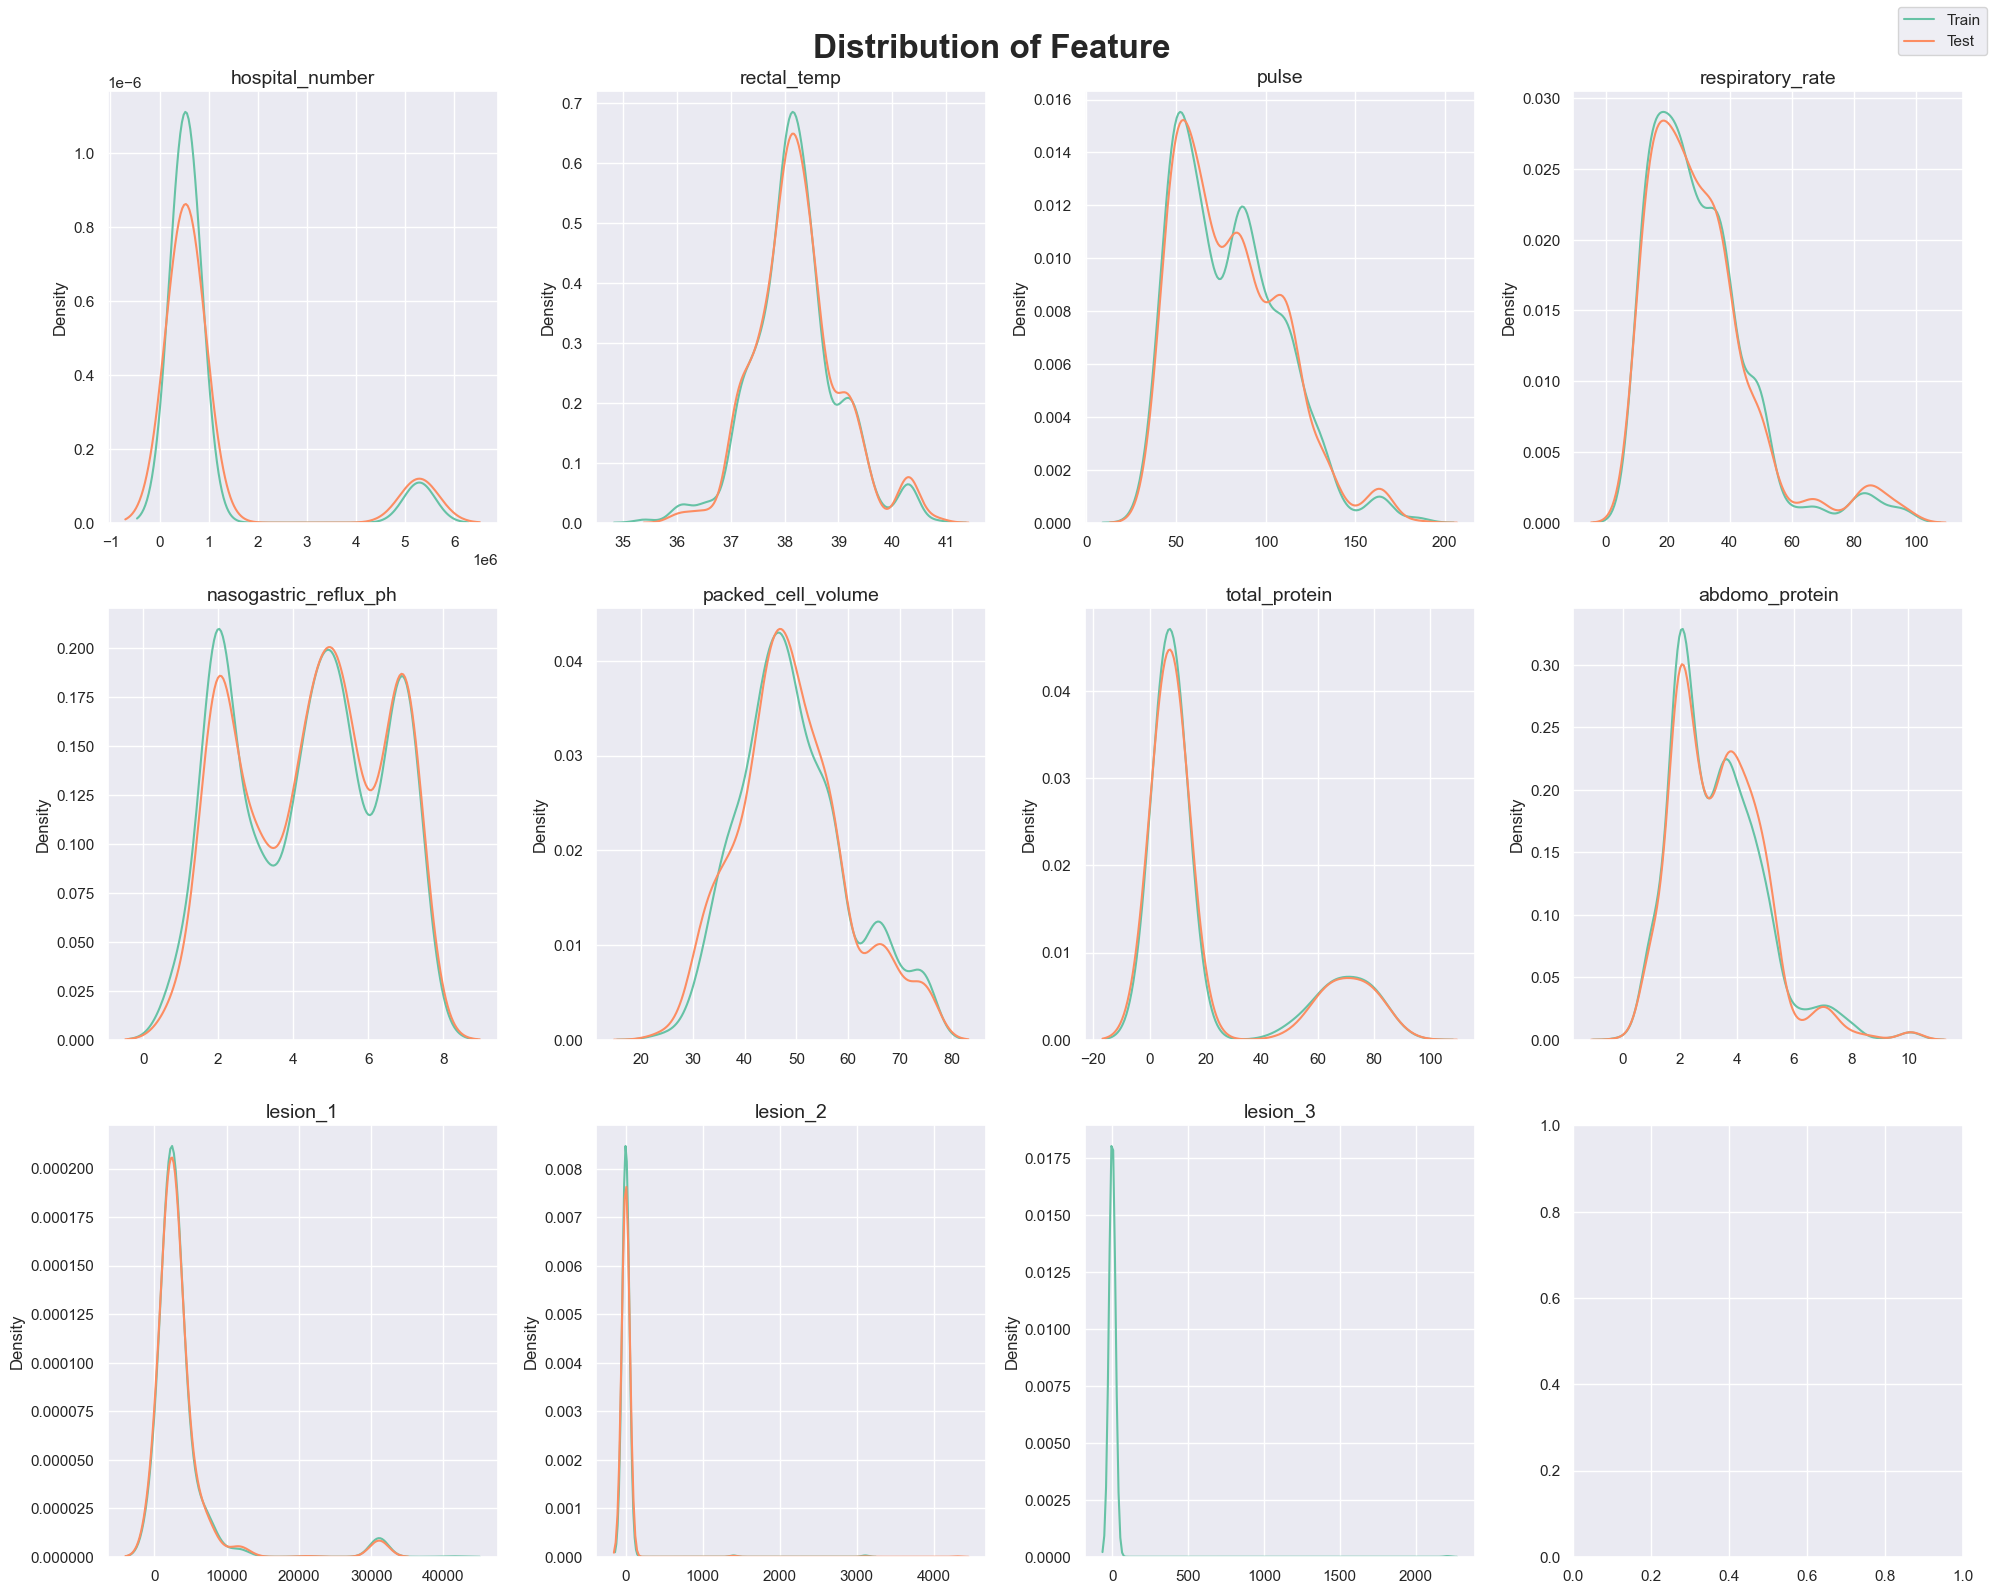

In [38]:
fig, ax = plt.subplots(3, 4)
ax = ax.flatten()
pal2 = sns.color_palette("Set2")
for i, column in enumerate(numerical_features):
    sns.kdeplot(train[column], ax=ax[i], color=pal2[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal2[1], warn_singular=False)

    ax[i].set_title(f'{column}', size=14)
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

#### Adversarial Validation(敵対性の検証)

- Adversarial Validation(敵対性の検証)の目的
    - 訓練用のデータセットとテスト用データセットの間で値の分布に差があるかないかを検証すること
- もしもしこの検証の結果得られるROC-AUCスコアが0.5に近いようなら、二つのデータセットは同じ分布を持っていると考えていい
    - しかしその値が0.5から離れているようなら、分布が同様とは言えない

- 信頼できるCV（Cross-validation）スコアは同様の分布を持つデータセットからのみ取得されるため、あらかじめCVスコアが信頼できることを確認しておくためこの検証が必要

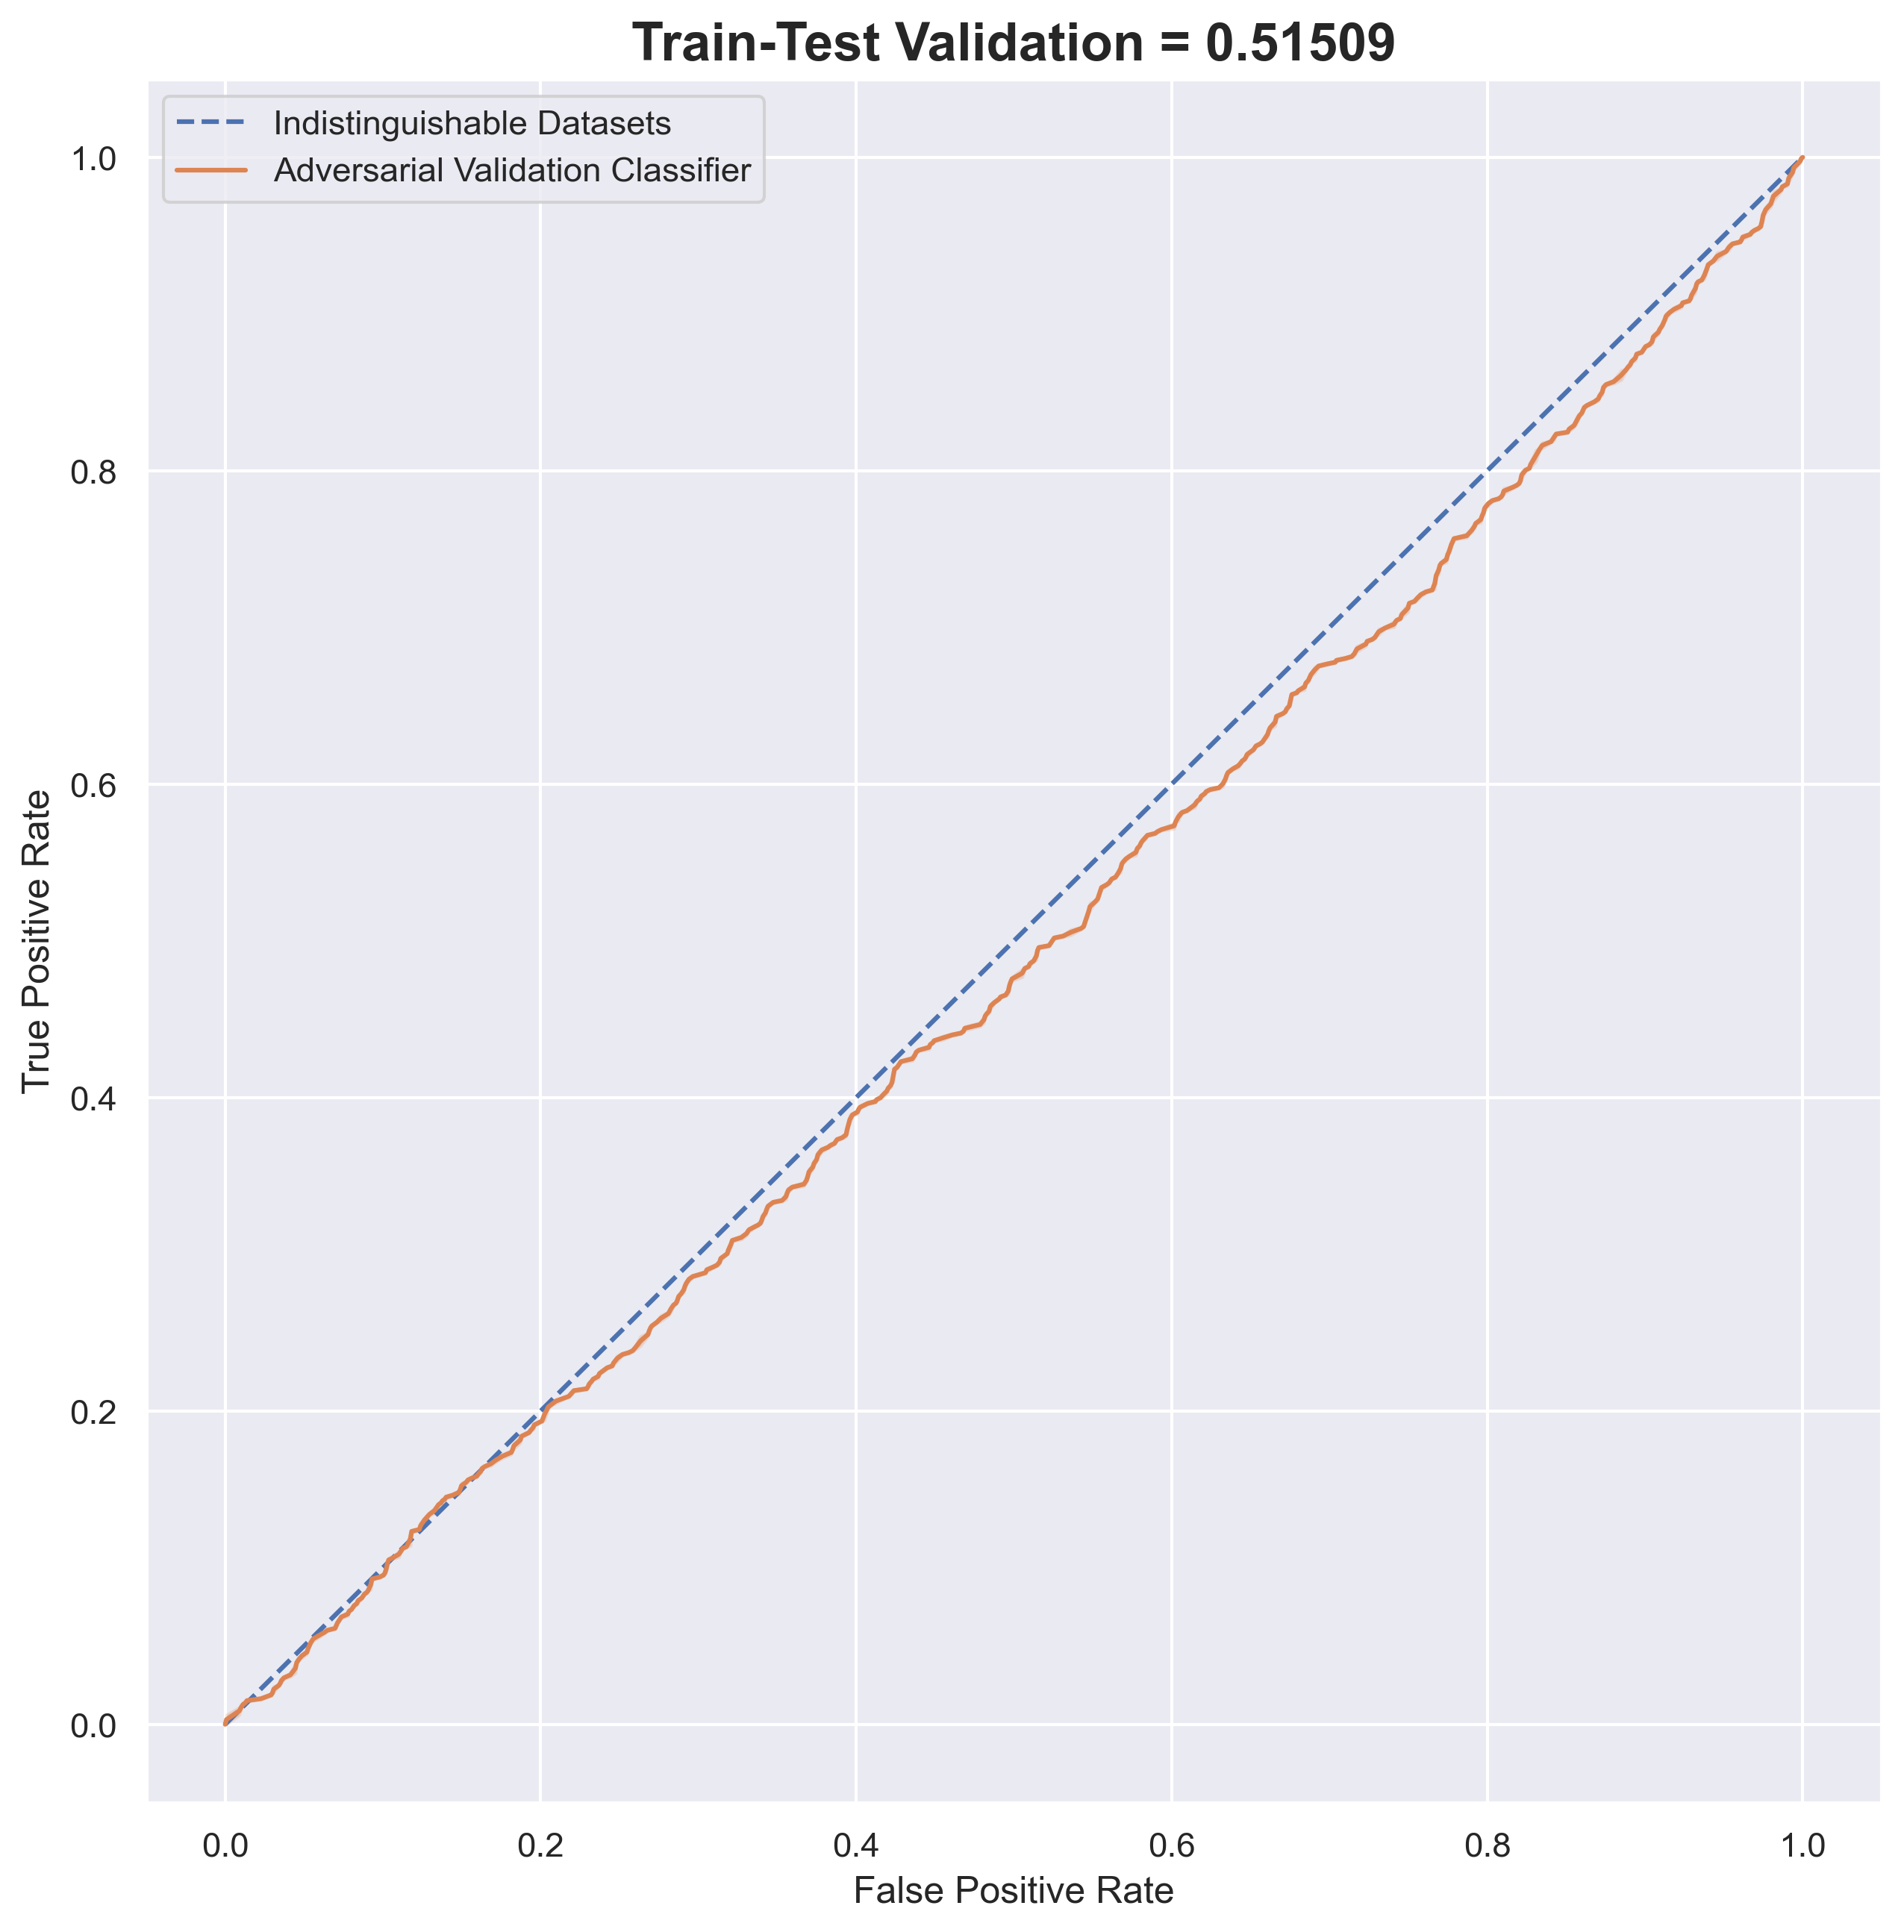

In [39]:
def adversarial_validation(dataset_1=train, dataset_2 = test, label='Train-Test'):
    adv_train = dataset_1.drop('outcome', axis=1) # 目的変数を指定する
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index=True)
    adv_shuffled = adv.sample(frac=1)
    adv_X = adv_shuffled.drop('is_test', axis=1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
        adv_lr = make_pipeline(OneHotEncoder(cols=categorical_features), XGBClassifier(random_state=42))
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:, 1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)

    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

    plt.figure(figsize=(10, 10), dpi=300)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight='bold', size=17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

adversarial_validation()

考察
- 若干不均衡？

## 円グラフと棒グラフ

##### カテゴリ型変数の分布

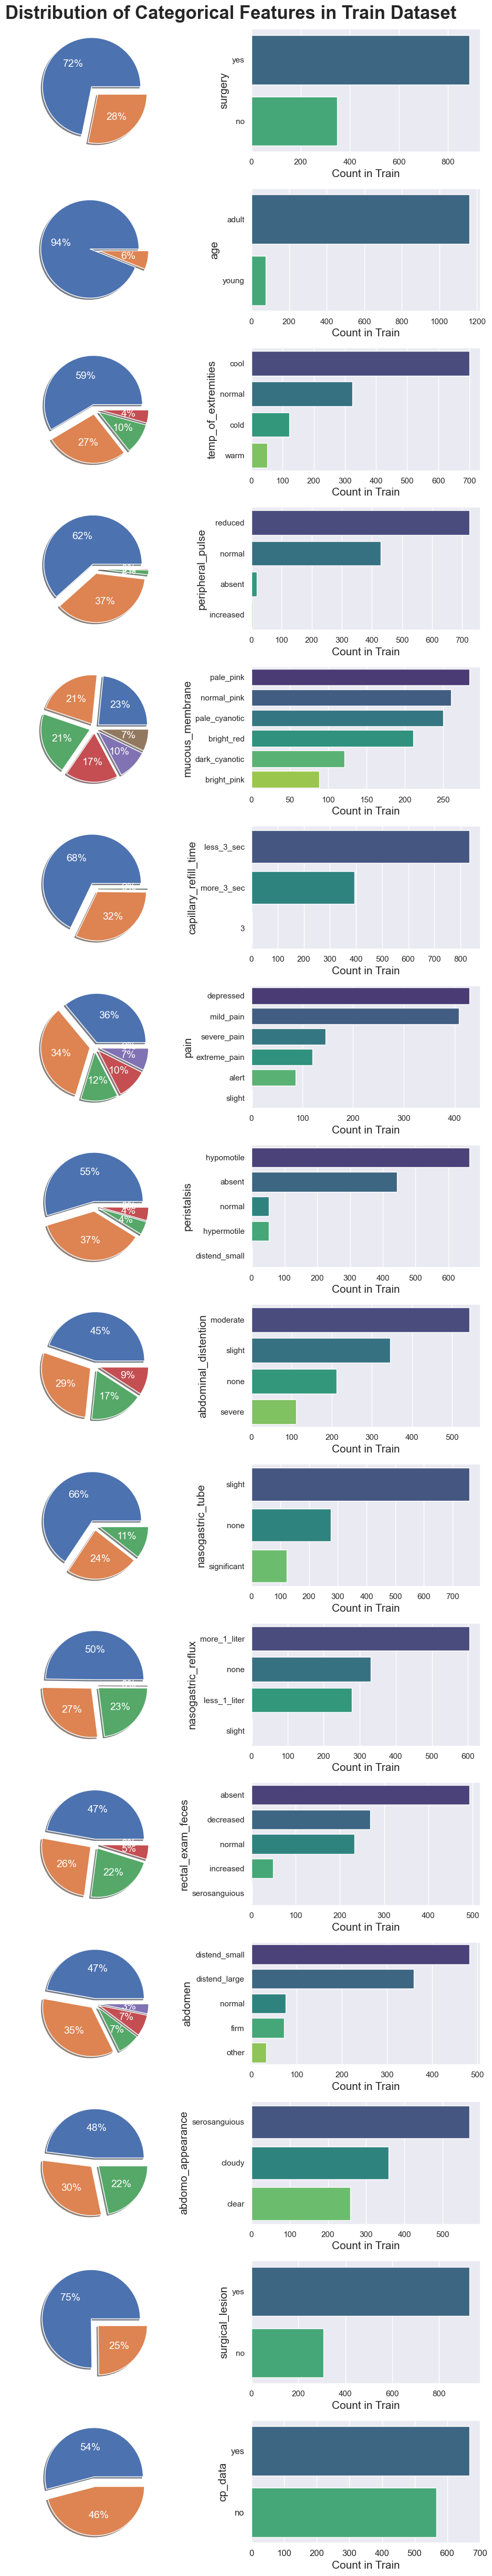

In [40]:
fig, ax = plt.subplots(len(categorical_features), 2, figsize=(10, 50))

for i, column in enumerate(categorical_features):
    ax[i][0].pie(
        train[column].value_counts(),
        shadow=True,
        explode=[.1 for i in range(train[column].nunique())],
        autopct='%1.f%%',
        textprops={'size': 14, 'color': 'white'}
    )

    sns.countplot(data=train, y=column, ax=ax[i][1], palette='viridis', order=train[column].value_counts().index)
    ax[i][1].yaxis.label.set_size(20)
    plt.yticks(fontsize=12)
    ax[i][1].set_xlabel('Count in Train', fontsize=15)
    ax[i][1].set_ylabel(f'{column}', fontsize=15)
    plt.xticks(fontsize=12)

fig.suptitle('Distribution of Categorical Features in Train Dataset \n\n', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

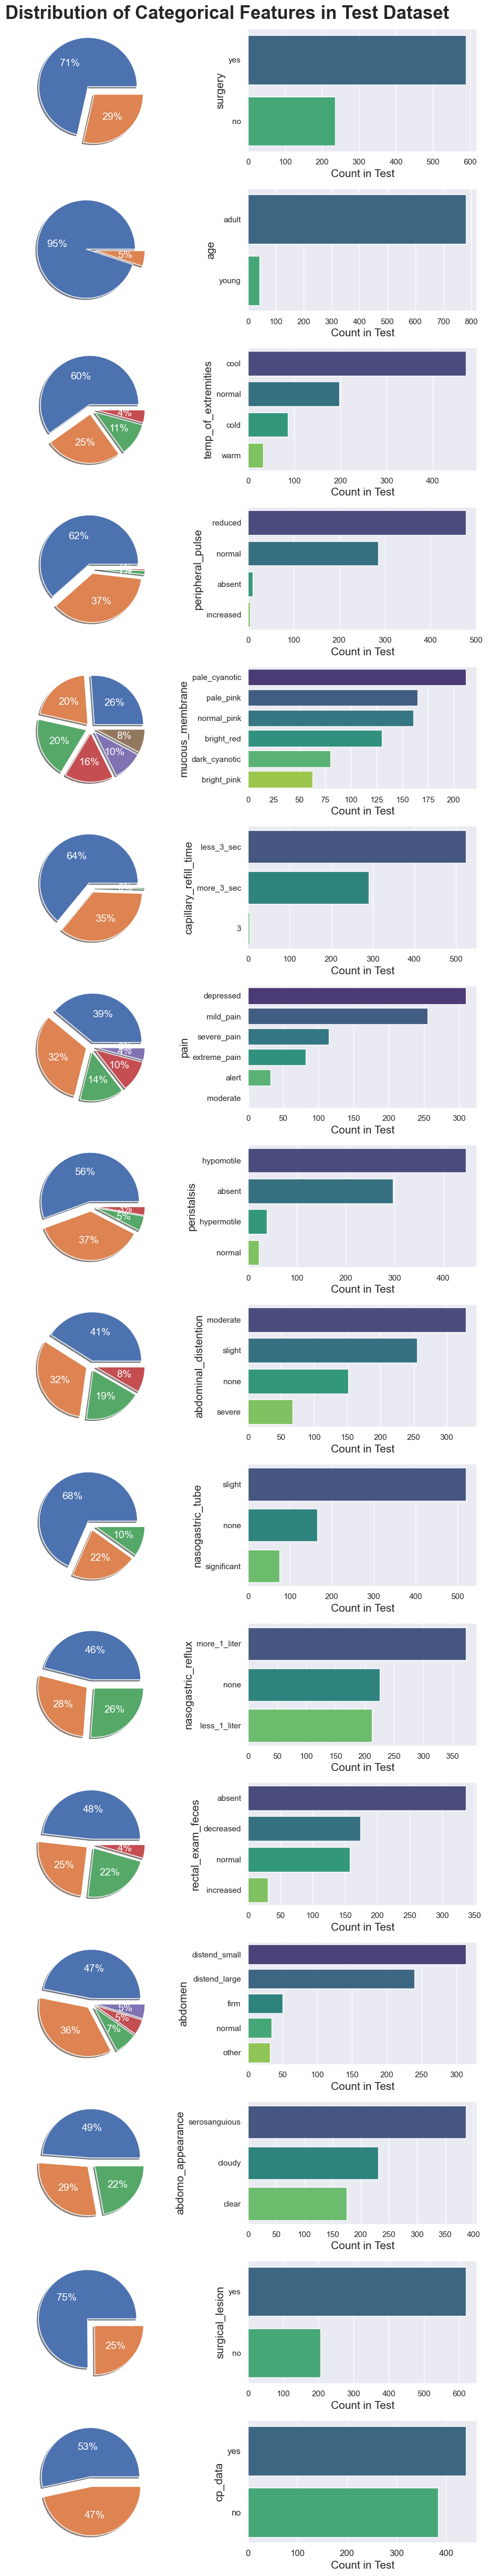

In [41]:
fig, ax = plt.subplots(len(categorical_features), 2, figsize=(10, 50))

for i, column in enumerate(categorical_features):
    ax[i][0].pie(
        test[column].value_counts(),
        shadow=True,
        explode=[.1 for i in range(test[column].nunique())],
        autopct='%1.f%%',
        textprops={'size': 14, 'color': 'white'}
    )

    sns.countplot(data=test, y=column, ax=ax[i][1], palette='viridis', order=test[column].value_counts().index)
    ax[i][1].yaxis.label.set_size(20)
    plt.yticks(fontsize=12)
    ax[i][1].set_xlabel('Count in Test', fontsize=15)
    ax[i][1].set_ylabel(f'{column}', fontsize=15)
    plt.xticks(fontsize=12)

fig.suptitle('Distribution of Categorical Features in Test Dataset \n\n', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

##### 目的変数のカテゴリ変数の分布

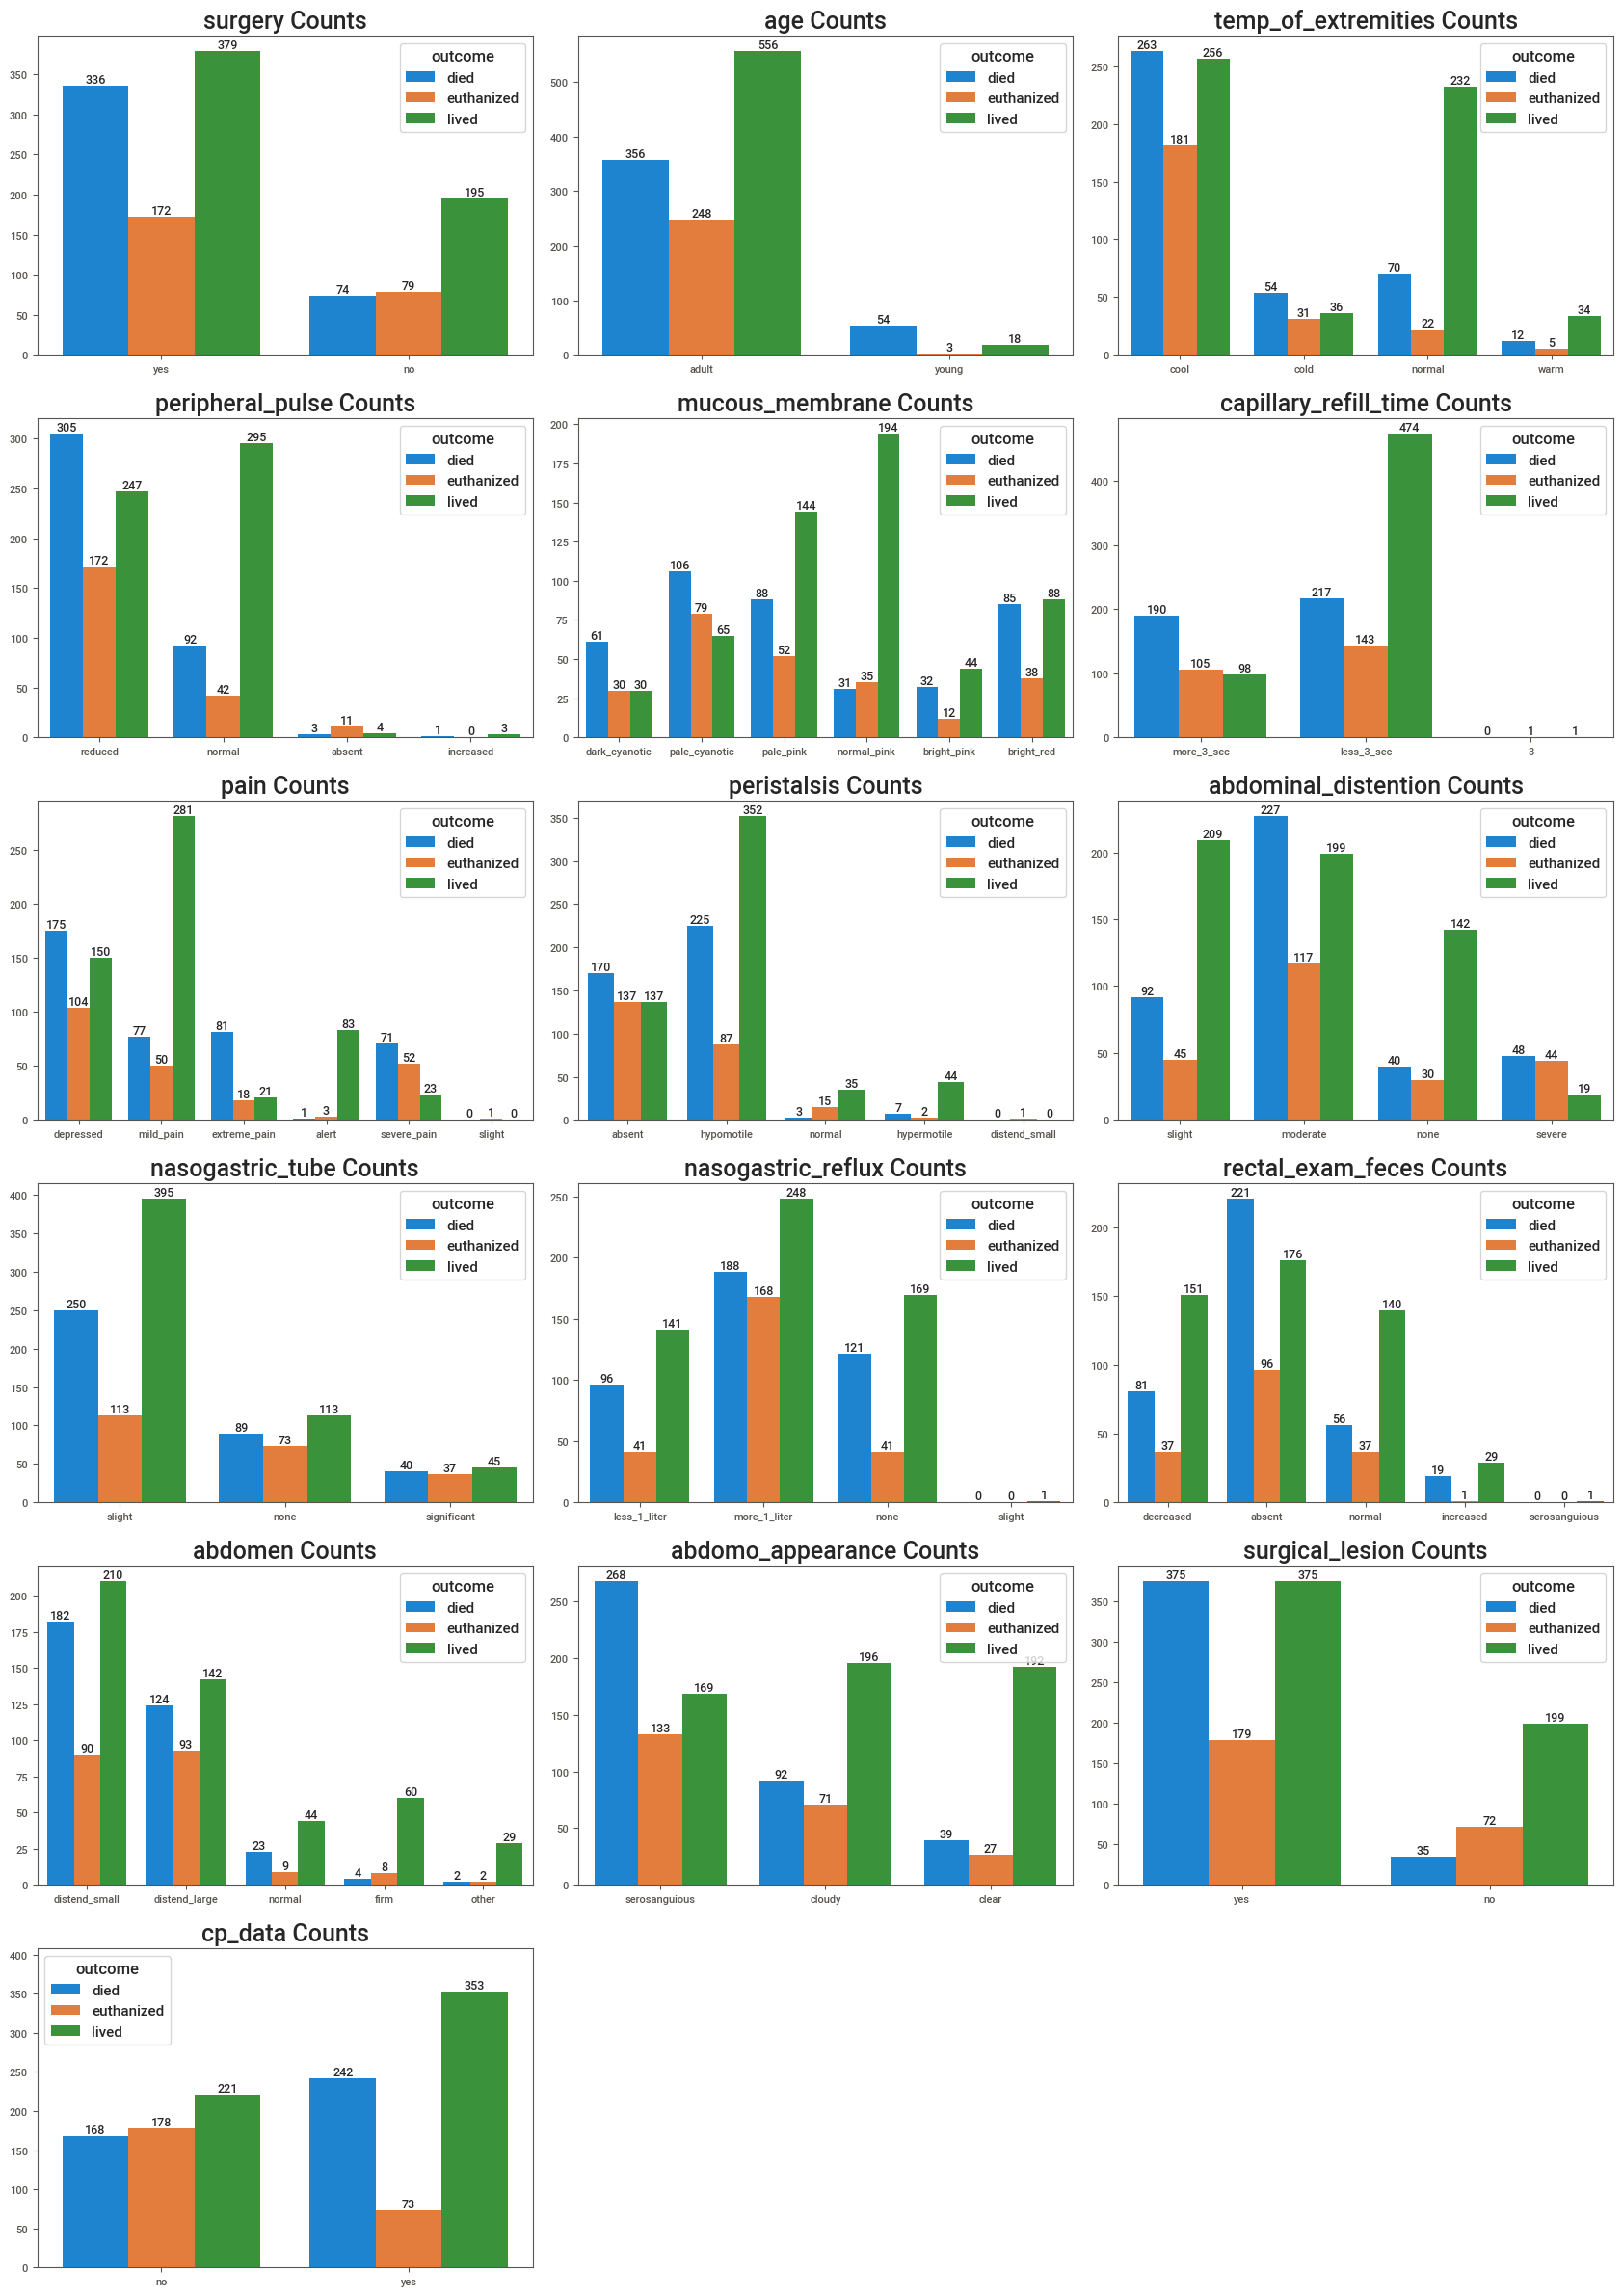

In [64]:
def plot_count(df, columns, n_cols, hue):
    n_rows = (len(columns)-1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i], hue=hue)
        
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x')

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)
    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_count(train, categorical_features, 3, 'outcome')

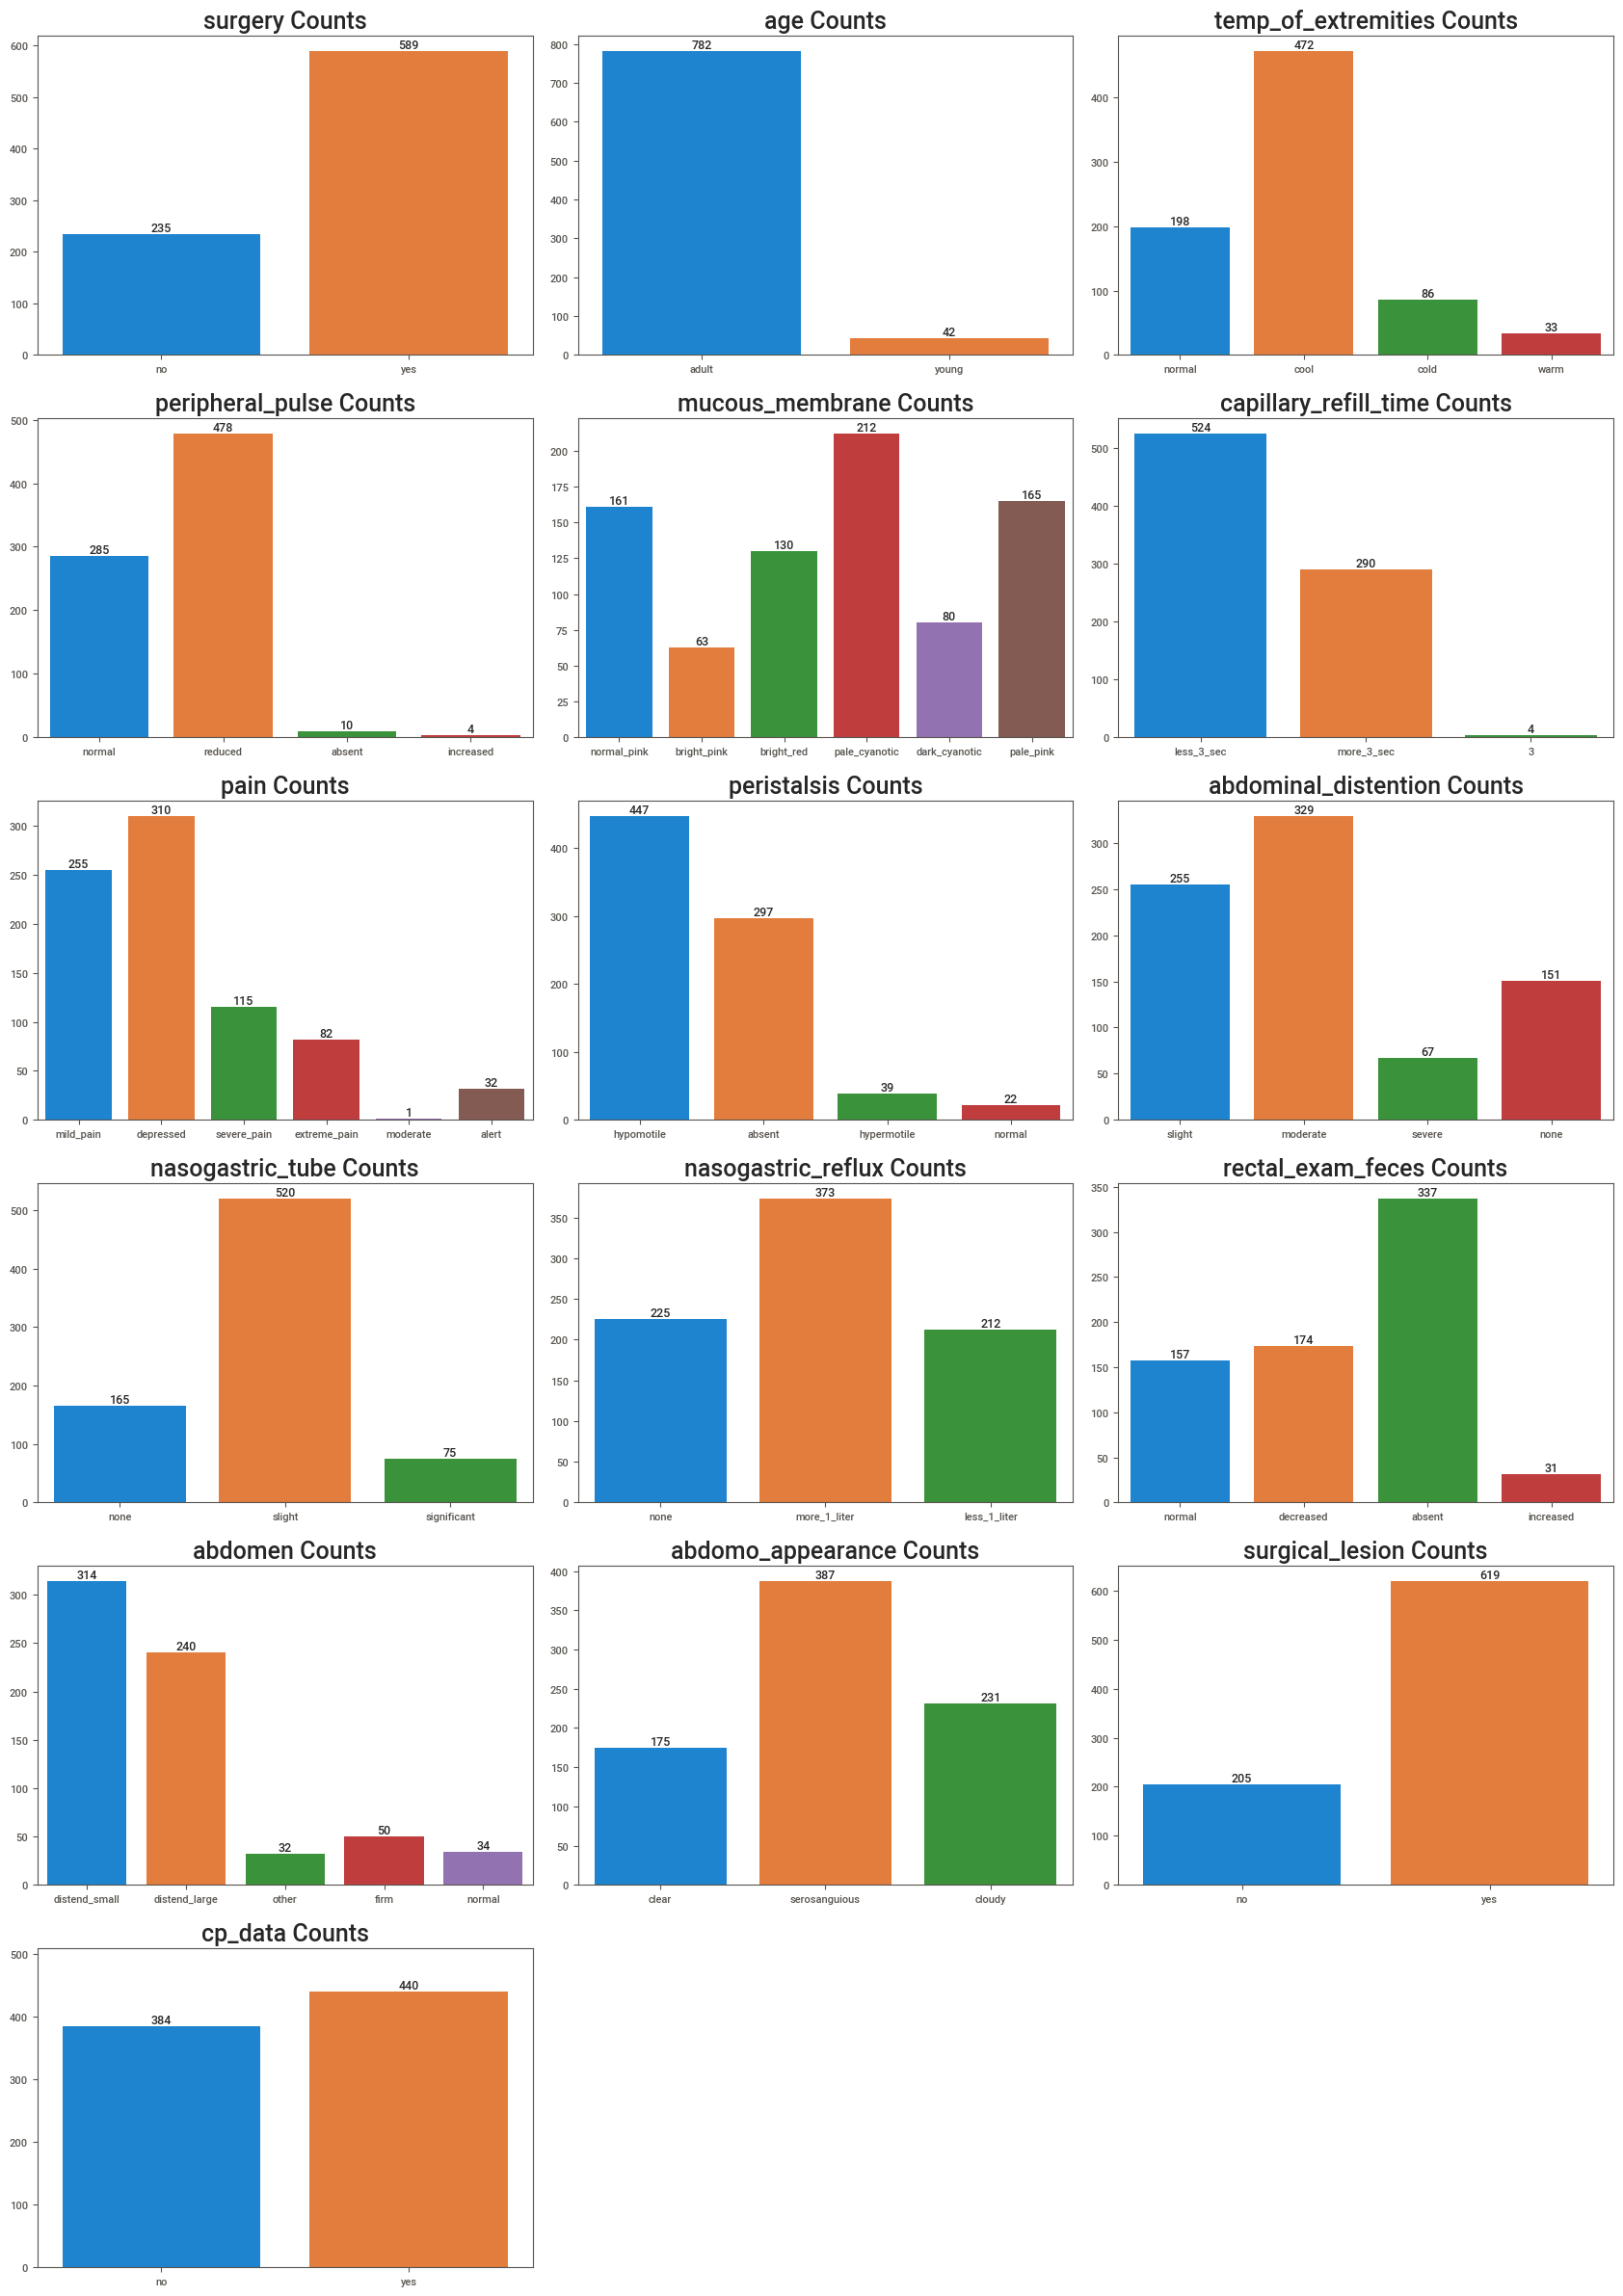

In [65]:
plot_count(test, categorical_features, 3, None)

考察
- 基本的にカテゴリ変数は特徴量エンジニアリングで変換可能な水準数である
- One-Hot Encodingであっても、特徴量が過剰に多くなることも避けられると考察した

### 円グラフと棒グラフ（目的変数）

In [42]:
# 目的変数を指定するための文字列の処理を行う
target_name_pie = target_name.replace('[', '').replace(']', '').replace("'", "")
# 今回限りの適用になるかもしれない

outcome
lived         574
died          410
euthanized    251
Name: count, dtype: int64


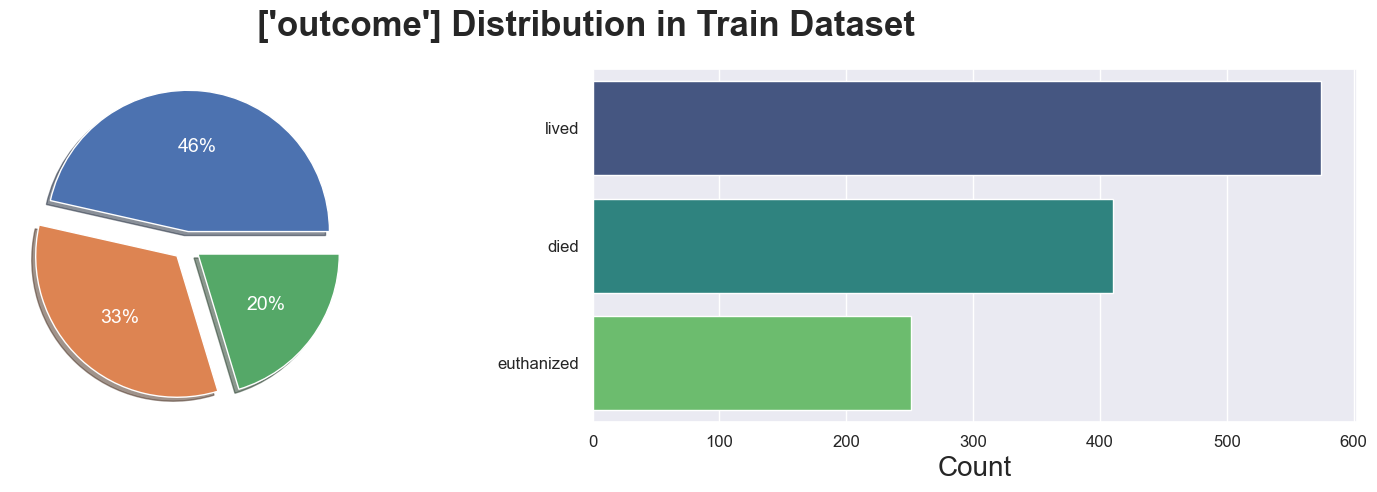

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    target.value_counts(),
    shadow=True,
    explode=[.1 for i in range(target.nunique())],
    autopct='%1.f%%',
    textprops={'size': 14, 'color':'white'}
)

sns.countplot(data=train, y=target_name_pie, ax=ax[1], palette='viridis', order=train[target_name_pie].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle(target_name + ' Distribution in Train Dataset', fontsize=25, fontweight='bold')
plt.tight_layout()

# 目的変数を数える
print(f'{train.outcome.value_counts()}') # 目的変数を指定する

### 箱ひげ図

数値型の説明変数

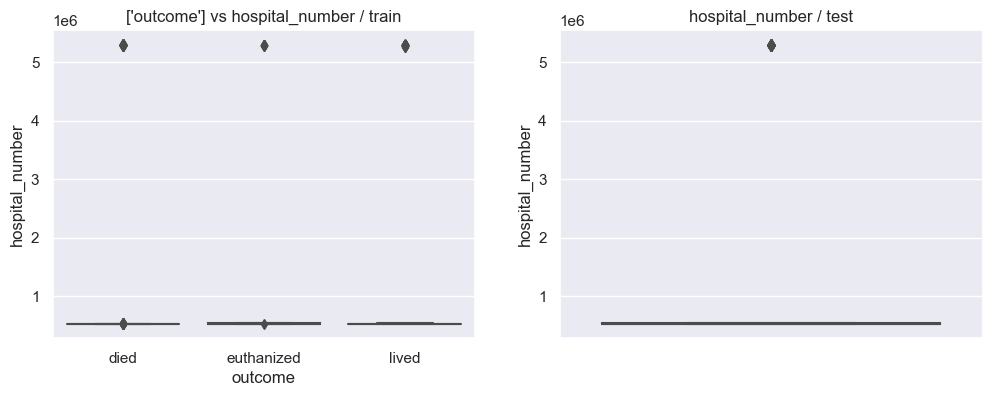

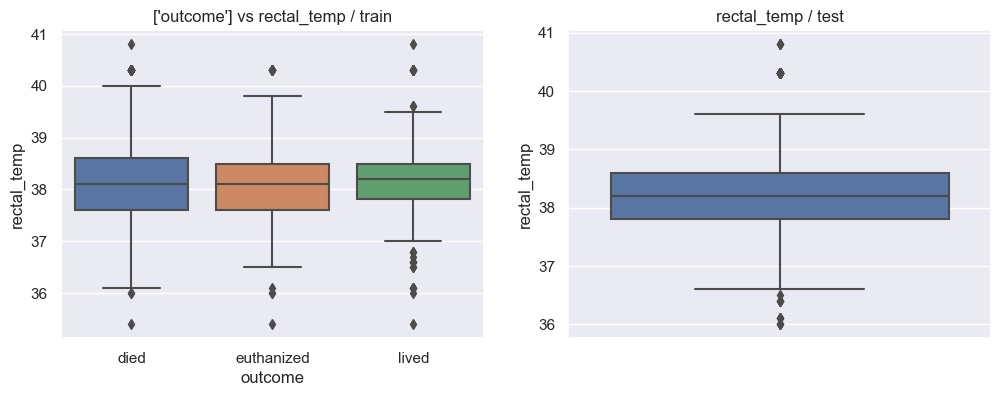

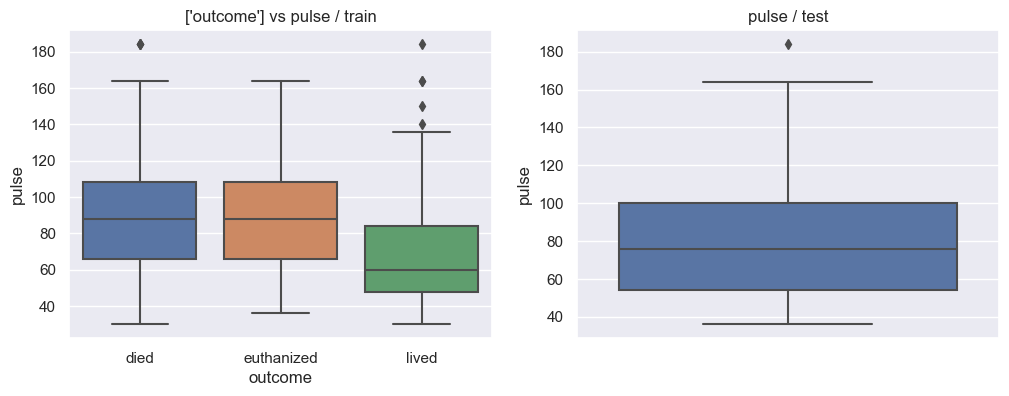

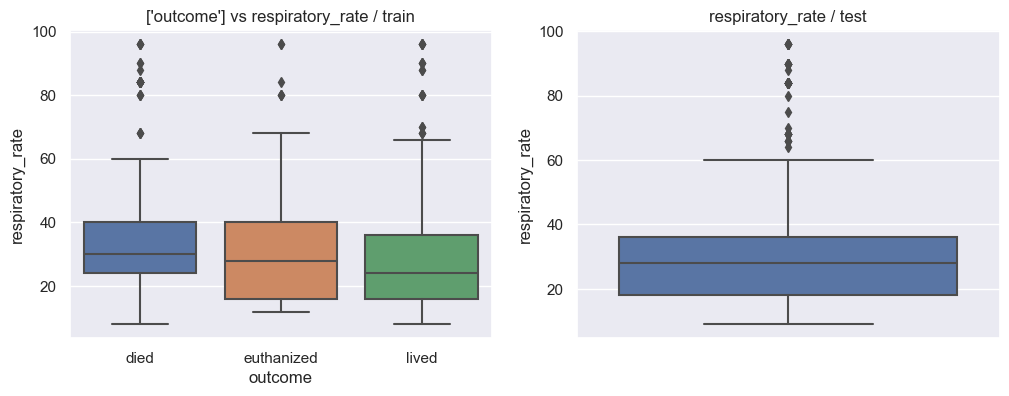

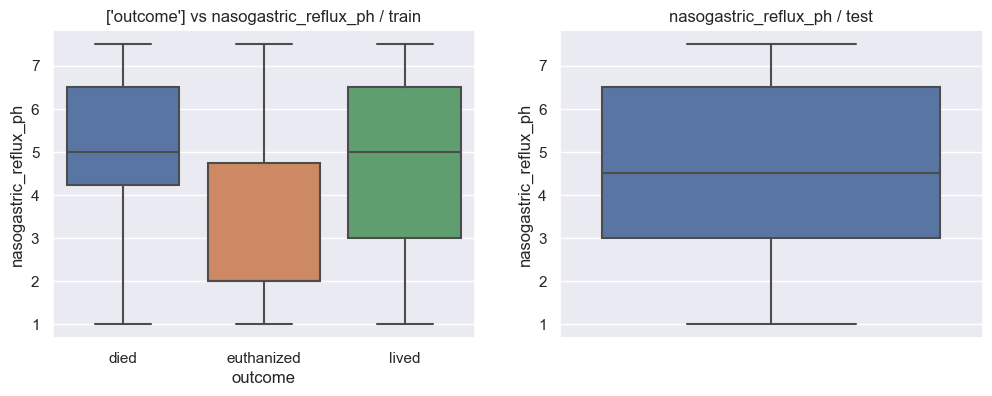

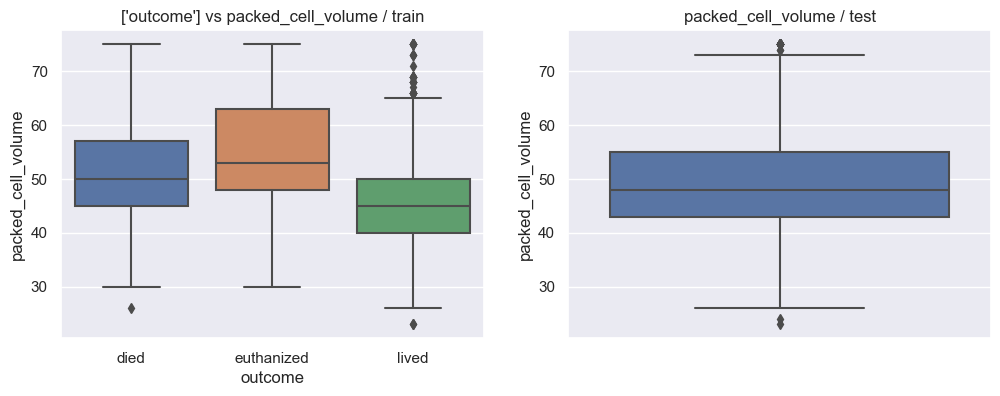

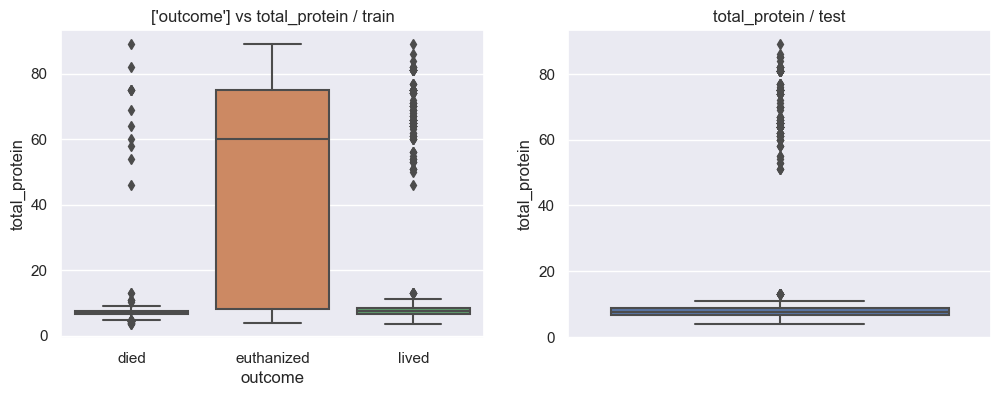

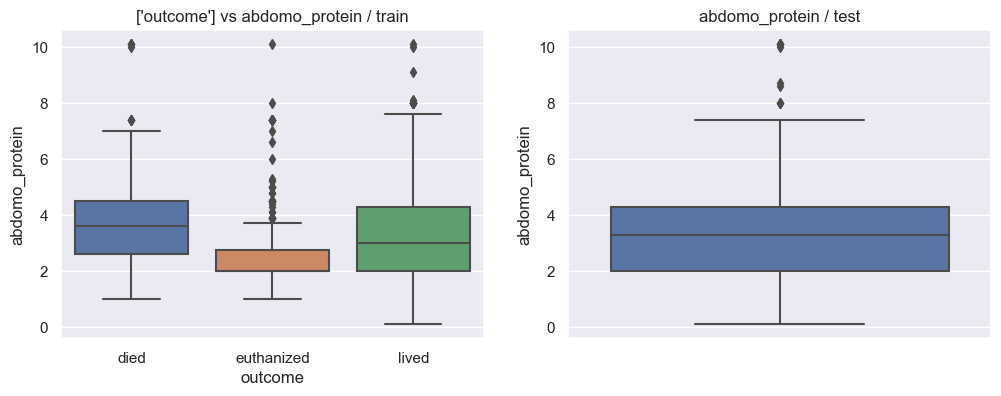

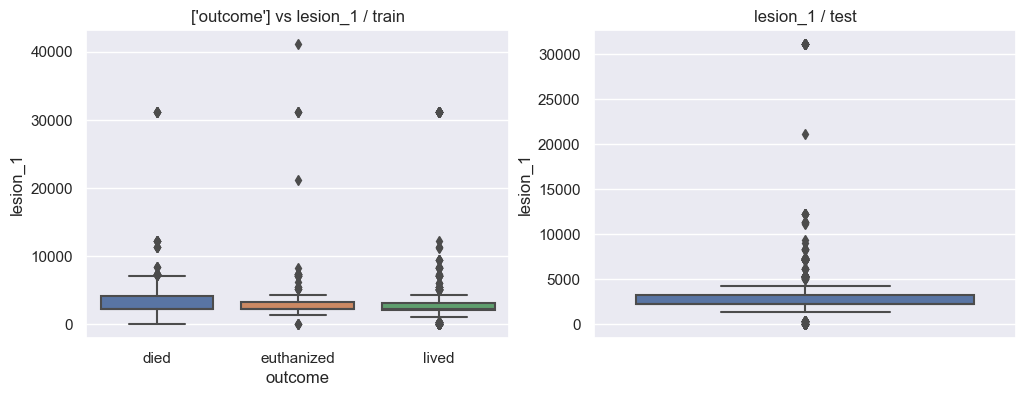

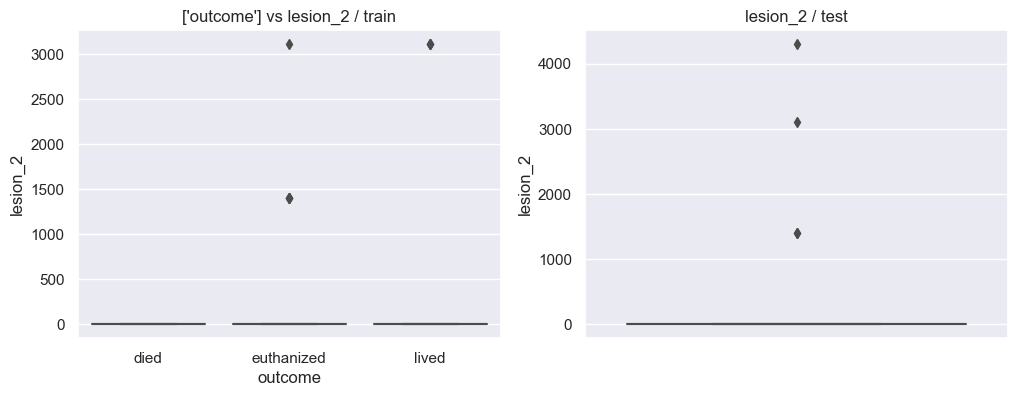

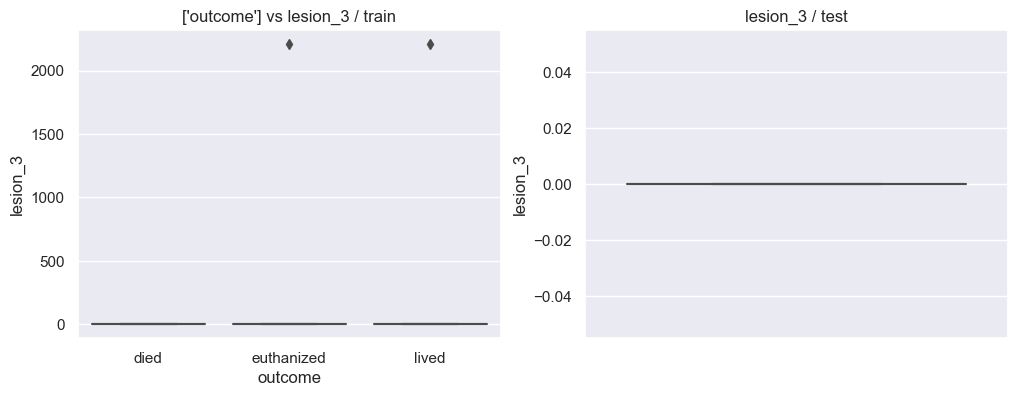

In [44]:
for feat in numerical_features:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

In [45]:
df_melted = pd.melt(X[numerical_features])

custom_colors = px.colors.qualitative.Plotly

fig = px.box(df_melted, x='variable', y='value', color='variable', color_discrete_sequence=custom_colors)
fig.update_layout(title='Box Plots')
fig.show()

#### 箱ひげ図（目的変数）

今回の目的変数は3水準以上あるため、箱ひげ図でのプロットが適していないため、行わない

### 特徴量の重要度評価

In [41]:
%%time

lgb = LGBMClassifier(
    random_state=42,
)

lgb.fit(X, y)
importance = lgb.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

: 

In [ ]:
feature_importance

importance
lesion_2                        0
lesion_3                        0
nasogastric_reflux_ph         631
abdomo_protein                796
respiratory_rate              797
rectal_temp                   946
total_protein                 965
packed_cell_volume           1032
pulse                        1071
lesion_1                     1229
hospital_number              1533

- 処理を行った後にカテゴリ変数も含めて評価を行う

考察
- lesion_2, lesion_3は重要度が確認されなかった
- 全体的に大きな差がない状態で重要度が確認された

### 相関（ヒートマップ）

<Axes: >

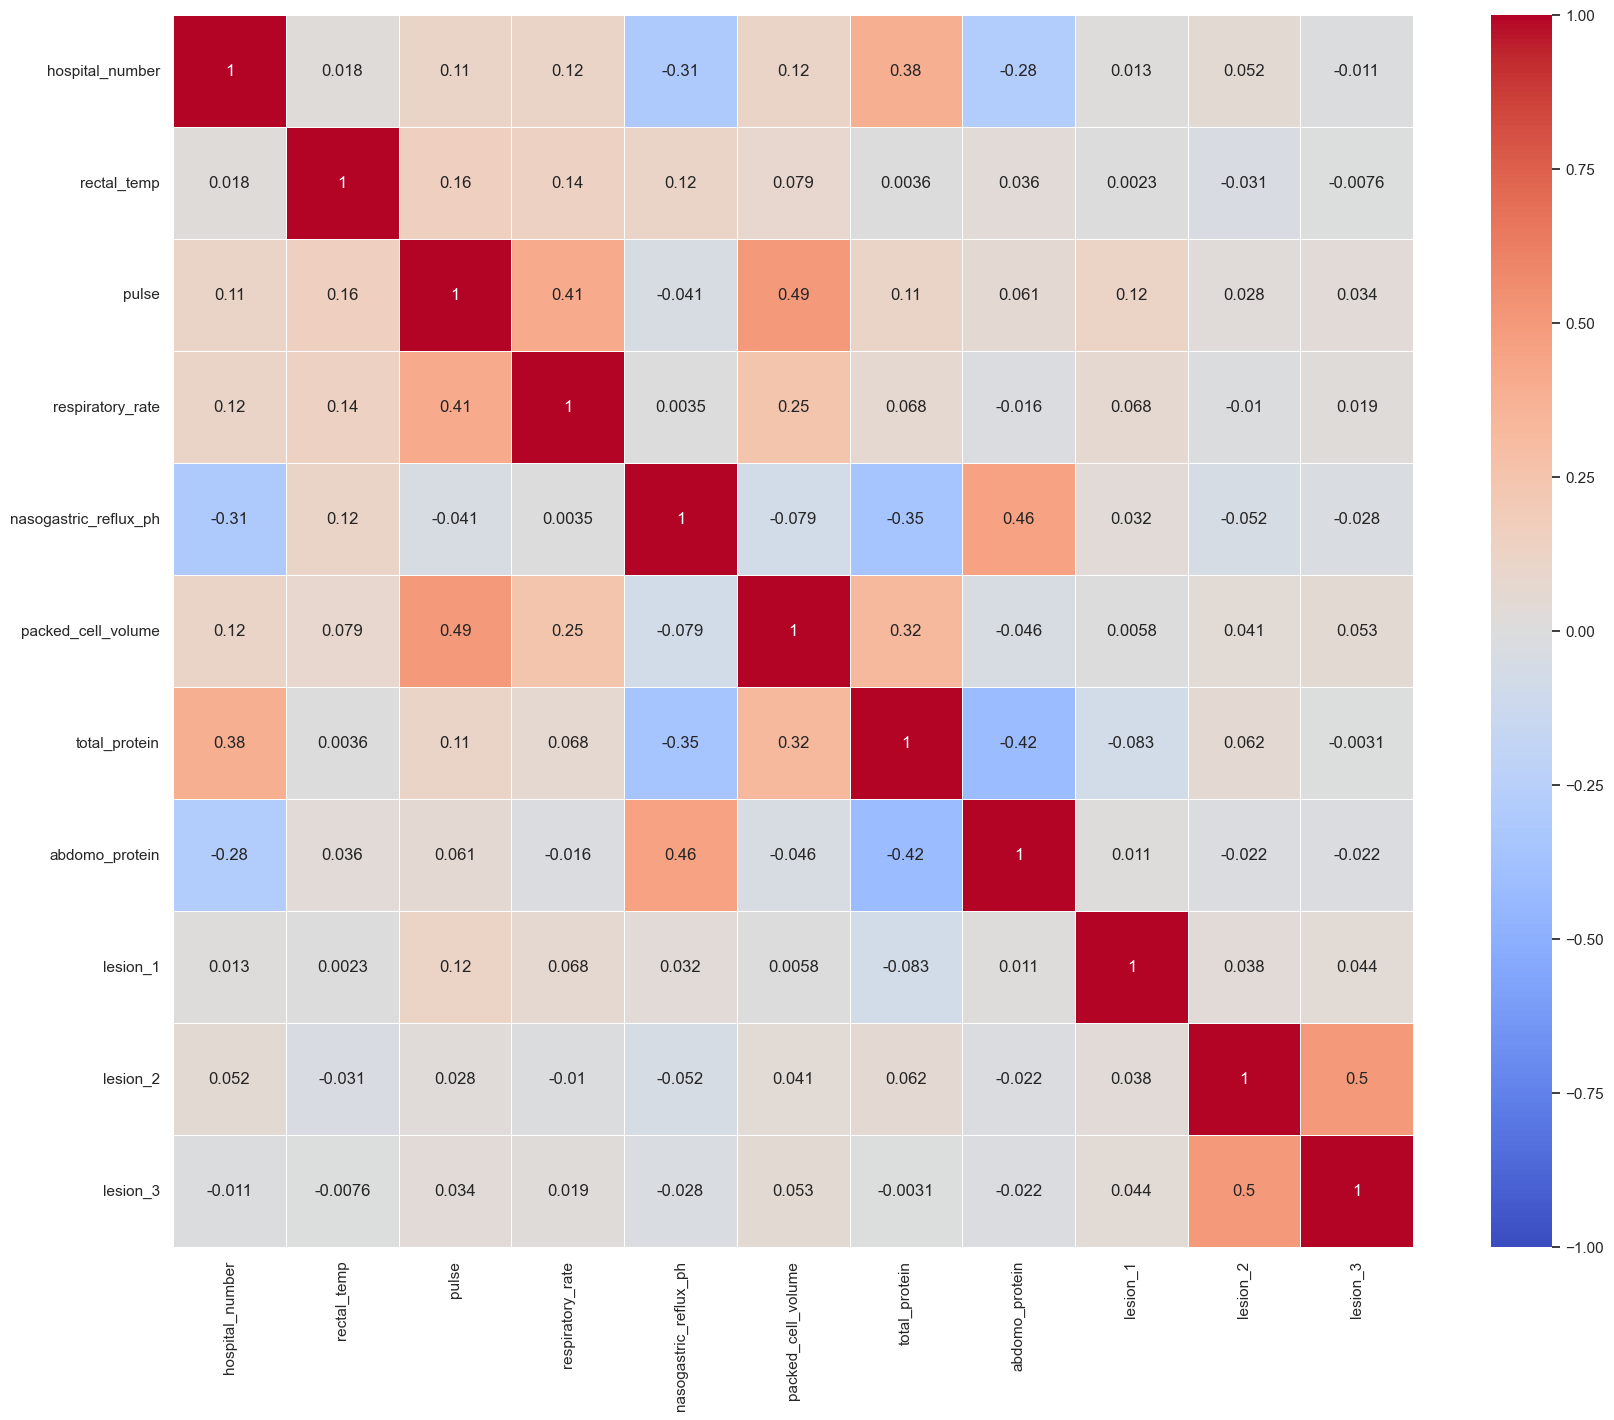

In [46]:
corr = train[numerical_features].corr(method='spearman')
plt.figure()
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

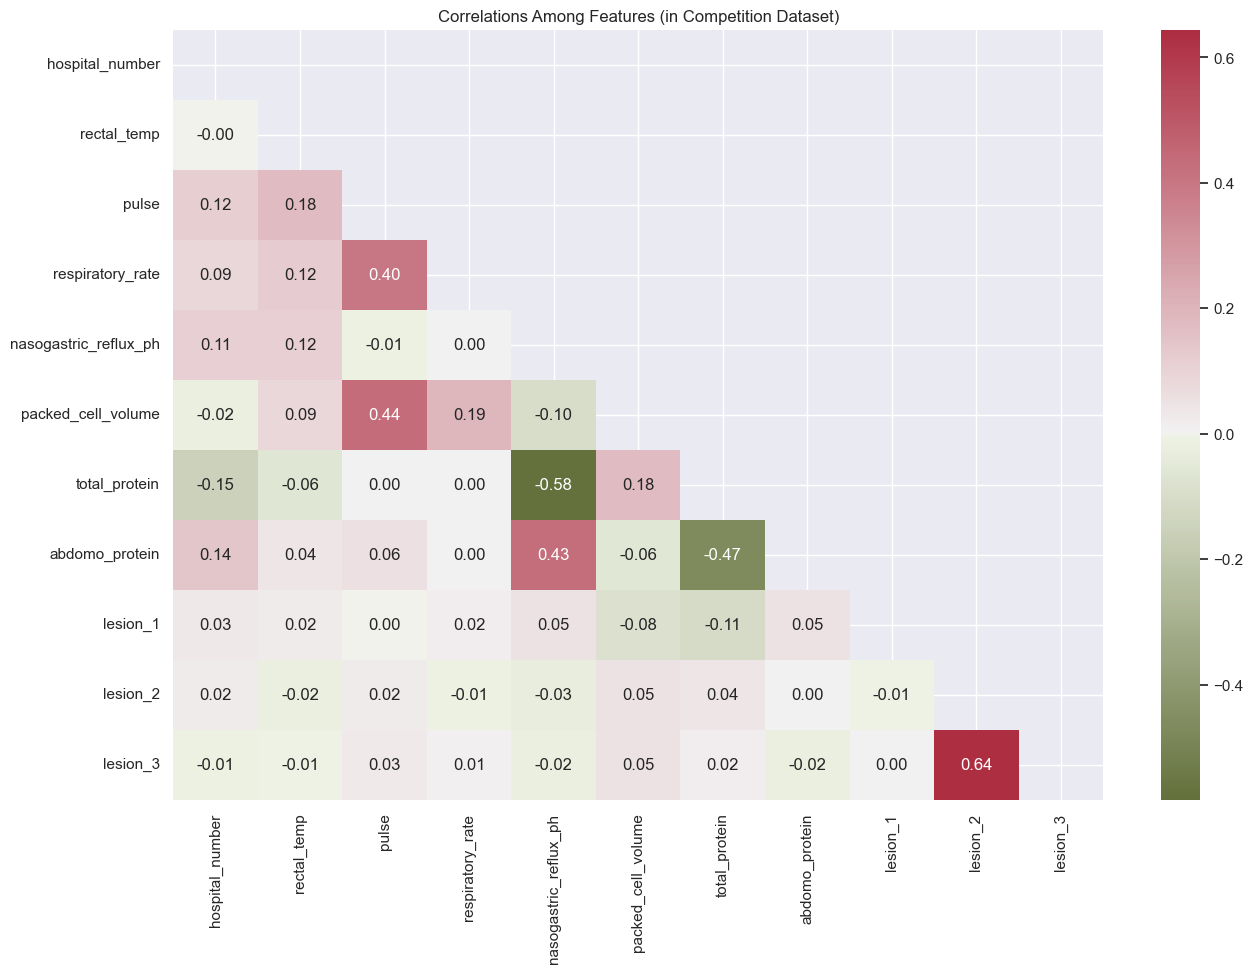

In [47]:
corr_mat_data = train[numerical_features].corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

#### 目的変数との相関の値が高いカラムについて調べる

In [48]:
# 目的変数がobject型（3水準以上）であるため、ラベルエンコーディングを適用する
le = LabelEncoder()
train['outcome_le'] = le.fit_transform(train['outcome'])

In [49]:
# 目的変数との相関の値が高い順に表示する
corr_target_data = train.corr()['outcome_le'] # 目的変数を指定する
corr_target_data.sort_values(ascending=False)

ValueError: could not convert string to float: 'yes'

ペアプロットは実行できなかった

In [50]:
# 目的変数と最も相関係数が高い説明変数の値ごとのデータ数を数える
corr_1_size = train.groupby('total_protein').size() # 説明変数を指定する
corr_1_size.sort_values(ascending=False).head(10)

total_protein
7.5     135
7.0      77
6.5      68
6.6      67
8.1      64
6.0      64
7.2      63
75.0     51
8.0      35
81.0     33
dtype: int64

### 階層的クラスタリング

- 特徴間の関係の強さと方向性を調べる
- 特徴をクラスタリングする

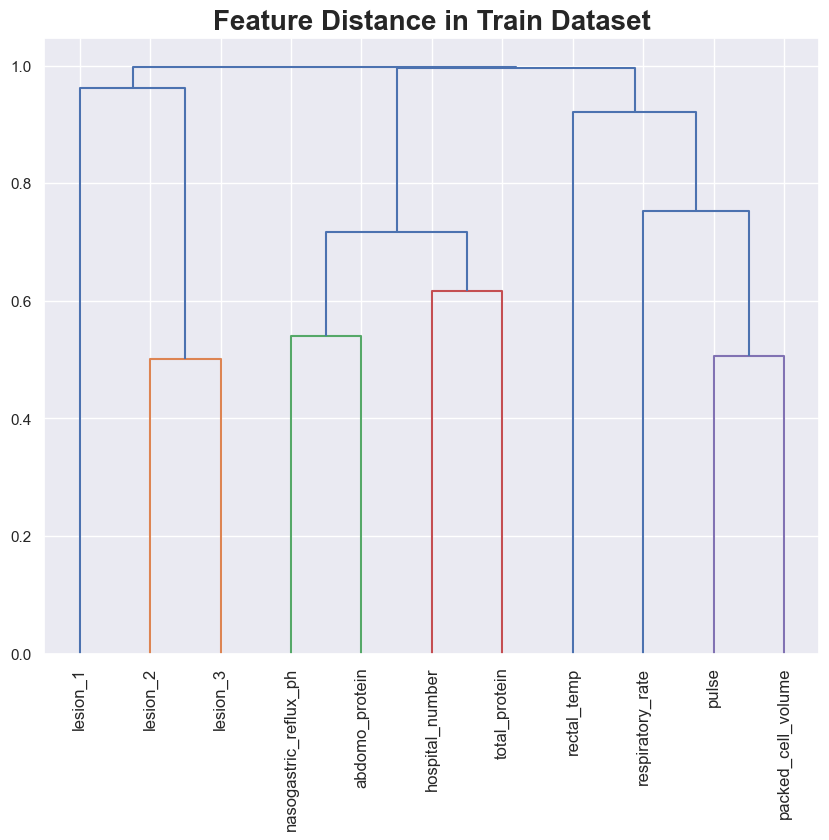

In [51]:
def distance(data, label = ''):
    corr = data.corr(method='spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

    plt.figure(figsize=(10, 8))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight='bold', size=20)
    plt.show()

distance(train[numerical_features], 'Train')

- テストデータはクラスタリングできなかったため、実施しなかった

考察
- lesion_1と lesion_2, lesion_3は別物と捉えていいと考察した

### 散布図

ペアプロットで近いことをしているため、今回は実施しなかった
- もしかしたら、書籍で全ての変数をプロットする方法が見つかるかもしれないから、それを実行するのもありかも？
- 結構色々な本でやっている。
- でも、負荷が大きい場合はやめる

### その他

#### 目的変数に関わるもの

## EDAの可視化するためのライブラリ

### sweetviz

In [52]:
from sweetviz import FeatureConfig

# 目的変数を数値として扱うように設定
feature_config = FeatureConfig(force_num=['outcome_le'])
report = sv.compare([train, "Train"], [test, "Test"], target_feat='outcome_le', feat_cfg=feature_config)
report.show_html(OUTPUT_DIR + "/EDA_sweetviz.html")


                                             |          | [  0%]   00:00 -> (? left)

Report /Users/ootsuka/Desktop/プログラミング/Kaggle/馬の健康への影響を予測する/output//EDA_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


0:99: execution error: ファイル“不特定のオブジェクト”が見つかりませんでした。 (-43)


## 実行時間を調べるために使う

In [53]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'5m56s'